In [1]:
# DiD_analysis.py

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from CausalCCUS.data_utils import prepare_panel_data, create_event_time
from CausalCCUS.vif import get_VIF_values
from CausalCCUS.diagnostics import did_balance_report, pretrend_test
from CausalCCUS.did import event_study_for_pta, att_overall, honest_did_bounds, att_o_estimator
from CausalCCUS.plotting import plot_corr_matrix, plot_by_sector_with_policies, plot_event_study, plot_raw_trends
from CausalCCUS.stats_utils import describe_by_group
from CausalCCUS.constants import POLICY_DATES

sns.set_theme()

"""# 1. Load and clean
df = pd.read_csv('df_merged_cleaned.csv')

# 3. VIF diagnostics


subset_countries = ['United States', 'Canada', 'China']
subset_ccus_sectors = ['Natural gas processing/LNG', 'Chemicals', 'Biofuels']

df_subset = df[
    (df['Country'].isin(subset_countries)) & 
    (df['CCUS_sector'].isin(subset_ccus_sectors))
].copy()"""

"# 1. Load and clean\ndf = pd.read_csv('df_merged_cleaned.csv')\n\n# 3. VIF diagnostics\n\n\nsubset_countries = ['United States', 'Canada', 'China']\nsubset_ccus_sectors = ['Natural gas processing/LNG', 'Chemicals', 'Biofuels']\n\ndf_subset = df[\n    (df['Country'].isin(subset_countries)) & \n    (df['CCUS_sector'].isin(subset_ccus_sectors))\n].copy()"

In [37]:
#df = pd.read_csv('df_merged_cleaned.csv')
p = create_event_time(df, group_vars=["Country","CCUS_sector"], treatment_var="d_log_eor_capacity", time_var="Year")
print('treated, control', count_treatment_status(p))
p.groupby(['Country', 'CCUS_sector']).ngroups

Preprocessing completed...
Treated units: 19395
Control units: 4331121
Treatment groups: 459
Event time range: -41 to 40
treated, control (19395, 4331121)


459

In [40]:
16558 + 132812

149370

In [43]:
treatment_rat = lambda x: int((x['d_log_eor_capacity'] > 0).mean() * 100)
treatment_rat(panel)

11

In [42]:
1 - (16558 / 149370)

0.8891477538997121

In [27]:
df_subset = pd.read_csv('df_sub.csv')

analytic_vars = [
    "Demand_electricity",
    "Demand_heat",
    "Demand_nuclear",
    "Demand_renewables_and_waste",
    "Supply_nuclear",
    "energy_demand_fossil_fuels",
    "CPI_growth",
    "GDP_per_capita_PPP",
    "renewable_to_fossil_supply_ratio"
]

def add_covariate_differences(df_subset: pd.DataFrame, covariates: list[str]) -> pd.DataFrame:
    """
    For each column in covariates, compute the first difference by unit.
    Returns a new DataFrame with additional columns named 'd_<covar>'.
    """
    covs = []
    df = df_subset.copy()
    group_cols = ['Country', 'CCUS_sector']
    for cov in covariates:
        diff_col = f'd_{cov}'
        df[diff_col] = df.groupby(group_cols)[cov].diff()
        covs.append(f'd_{cov}')
    
    return df, covs

df_subset, new_covariates = add_covariate_differences(df_subset, analytic_vars)

new_covs =  [
    "d_Demand_electricity",
    "d_Demand_heat",
    "d_Demand_nuclear",
    "d_Demand_renewables_and_waste",
    "d_Supply_nuclear",
    "d_energy_demand_fossil_fuels",
    "d_CPI_growth",
    "d_GDP_per_capita_PPP",
    "d_renewable_to_fossil_supply_ratio"
]

df_subset = df_subset.fillna(0)

df_subset.groupby(['Country', 'emissions_sector']).ngroups

108

In [30]:
df_subset.groupby(['Country', 'Sector']).ngroups

18

In [50]:
get_VIF_values(df, analytic_vars)

,feature,VIF
0,const,4.145883
1,Demand_nuclear,1.320678
2,Supply_nuclear,1.213169
3,energy_demand_fossil_fuels,1.150308
4,Demand_heat,1.134151
5,renewable_to_fossil_supply_ratio,1.107014
6,Demand_electricity,1.094066
7,GDP_per_capita_PPP,1.075590
8,Demand_renewables_and_waste,1.066840
9,CPI_growth,1.007820


In [9]:
# 2. Balance & sample selection
import numpy as np
balance = did_balance_report(
    df_subset,
    cluster_col="Country_CCUS_Sector",
    time_col="Year",
    treatment_var="d_log_eor_capacity",
    outcome_col="d_log_emissions",
)
# (prints summary & MDE)

Total observations: 149370
Time span: 1980 – 2022 (43 periods)
Overall treated proportion: 11.09%

Treatment share by year:
Year
1980    0.000000
1981    0.000000
1982    0.000400
1983    0.000000
1984    0.000000
1985    0.000000
1986    0.080786
1987    0.080786
1988    0.080786
1989    0.080786
1990    0.079741
1991    0.080786
1992    0.080963
1993    0.078603
1994    0.077586
1995    0.075949
1996    0.075949
1997    0.075949
1998    0.075000
1999    0.075820
2000    0.075820
2001    0.075820
2002    0.075472
2003    0.068966
2004    0.069632
2005    0.068182
2006    0.068182
2007    0.067797
2008    0.067797
2009    0.066483
2010    0.112853
2011    0.158787
2012    0.159712
2013    0.177671
2014    0.178313
2015    0.178514
2016    0.177671
2017    0.168950
2018    0.168563
2019    0.167800
2020    0.167989
2021    0.194328
2022    0.207865

No valid cluster_col provided; skipping cluster diagnostics.

---
MDE (80% power, 5% α): 0.034 SDs of `d_log_emissions`
(clusters used: 149

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/rjsou/Documents/PhD/Causal-CCUS/Notebooks/Figures/Final/Figures/Final/final_corr.png'

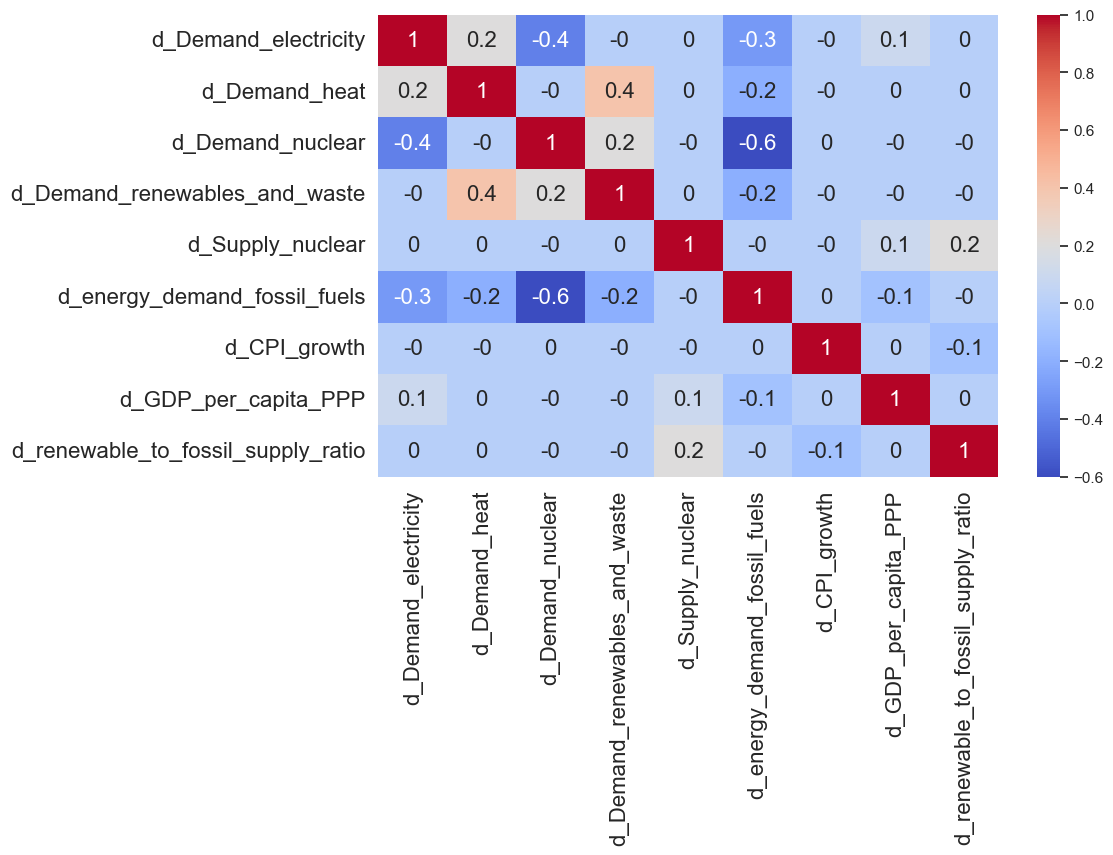

In [50]:
# 4. Correlation heat-map
plot_corr_matrix(df_subset, new_covariates, title="Pre-DiD Correlations", save_path='final_corr.png')

In [36]:
len(df_subset[new_covariates])

149370

In [3]:
import pandas as pd
import statsmodels.formula.api as smf
from typing import Optional, Literal, List, Dict

# -----------------------------------------------------------
# Helper to build fixed-effect strings only once
# -----------------------------------------------------------
def _build_fe_terms(fe_list: List[str]) -> List[str]:
    """
    Takes a list of column names and returns ['C(col1)', 'C(col2)', …]
    dropping duplicates while preserving order.
    """
    seen, out = set(), []
    for col in fe_list:
        if col not in seen:
            out.append(f"C({col})")
            seen.add(col)
    return out


# -----------------------------------------------------------
# 1. Event-study (visual / PTA) estimator
# -----------------------------------------------------------
"""def event_study_for_pta(
    df: pd.DataFrame,
    outcome_var: str = "d_log_emissions",
    treatment_var: str = "d_log_eor_capacity",
    event_time_var: str = "event_time",
    pre_window: int = 5,
    post_window: int = 10,
    fe_cols: List[str] = None,
    cluster_var: str = "treatment_group",
    covariates: Optional[List[str]] = None,
) -> Dict:
    fe_cols = fe_cols or ["treatment_group", "Year"]
    data = df.copy()
    # 1 • binarise treatment
    data["treated"] = (data[treatment_var] > 0).astype(int)

    # 2 • slice event window
    data = data.loc[data[event_time_var].between(-pre_window, post_window)]
    if data.empty:
        return {"model": None, "interaction_terms": [], "pre_terms": []}

    # 3 • build event dummies & interactions (omit t = –1)
    interaction_terms = []
    for t in range(-pre_window, post_window + 1):
        if t == -1:
            continue
        base = f"event_{t}" if t >= 0 else f"event_m{abs(t)}"
        data[base] = (data[event_time_var] == t).astype(int)
        inter = f"{base}_treated"
        data[inter] = data[base] * data["treated"]
        interaction_terms.append(inter)

    # 4 • assemble RHS
    rhs = interaction_terms + (covariates or []) + _build_fe_terms(fe_cols)
    formula = f"{outcome_var} ~ " + " + ".join(rhs)

    # **NEW**: drop any rows with NaNs in outcome, regressors, or cluster id
    """subset = [outcome_var] + [cluster_var] + rhs
    data_clean = data.dropna(subset=subset)"""

    # 5 • fit clustered regression
    model = smf.ols(formula, data=data).fit(
        cov_type="cluster",
        cov_kwds={"groups": data[cluster_var]}
    )

    # 6 • joint F-test on pre-treatment leads
    pre_terms = [c for c in interaction_terms if c.startswith("event_m")]
    p_val = float(
        model.f_test([f"{c} = 0" for c in pre_terms]).pvalue
    ) if pre_terms else float("nan")

    return {
        "model": model,
        "interaction_terms": interaction_terms,
        "pre_terms": pre_terms,
        "p_value": p_val,
        "n_pre_periods": len(pre_terms),
        "n_post_periods": len(interaction_terms) - len(pre_terms),
    }
# ------------------------------------------------------------------"""
# 3. Honest DiD bounds remain unchanged
#    (pass att_o_estimator() output + event_study_for_pta() pre-lead info)
# ------------------------------------------------------------------
def honest_did_bounds(
    pta_results: dict,
    att_estimate: float,
    std_error: float,
    M_values=(0.5, 1, 1.5, 2)
) -> dict:
    pre_coefs = [pta_results["model"].params[p] for p in pta_results["pre_terms"]]
    v = max(abs(c) for c in pre_coefs) if pre_coefs else 0.0
    out = {}
    for M in M_values:
        shift = M * v
        lo = att_estimate - 1.96 * std_error - shift
        hi = att_estimate + 1.96 * std_error + shift
        out[f"M={M}"] = (lo, hi)
    return out


SyntaxError: invalid syntax (3862504021.py, line 61)

In [3]:
def event_study_for_pta(
    df: pd.DataFrame,
    outcome_var: str = "d_log_emissions",
    treatment_var: str = "d_log_eor_capacity",
    event_time_var: str = "event_time",
    pre_window: int = 5,
    post_window: int = 10,
    fe_cols = None,
    cluster_var: str = "treatment_group",
    covariates = None,
):
    # Default to unit and year fixed effects
    fe_cols = fe_cols or ["treatment_group", 'Sector', 'emissions_sector']
    data = df.copy()

    # 1 • binarise treatment
    data["treated"] = (data[treatment_var] > 0).astype(int)

    # 2 • slice event window
    data = data.loc[data[event_time_var].between(-pre_window, post_window)]
    if data.empty:
        return {"model": None, "interaction_terms": [], "pre_terms": []}

    # 3 • build event dummies & interactions (omit t = –1)
    interaction_terms = []
    for t in range(-pre_window, post_window + 1):
        if t == -1:
            continue
        base = f"event_{t}" if t >= 0 else f"event_m{abs(t)}"
        data[base] = (data[event_time_var] == t).astype(int)
        inter = f"{base}_treated"
        data[inter] = data[base] * data["treated"]
        interaction_terms.append(inter)

    # 4 • assemble RHS
    fe_terms = [f"C({col})" for col in fe_cols]
    rhs = interaction_terms + (covariates or []) + fe_terms
    formula = f"{outcome_var} ~ " + " + ".join(rhs)

    # 5 • drop rows with any missing in:
    #     - outcome, treatment_group, Year
    #     - all covariates, all event and interaction terms
    required_columns = (
        [outcome_var, cluster_var, event_time_var]
        + [treatment_var]
        + (covariates or [])
        + interaction_terms
        + fe_cols  # dropna on the raw fe columns, not “C(…)”
    )
    data_clean = data.dropna(subset=required_columns)

    # 6 • fit clustered regression
    model = smf.ols(formula, data=data_clean).fit(
        cov_type="cluster",
        cov_kwds={"groups": data_clean[cluster_var]}
    )

       # After fitting your event study model
    pre_terms = [f"C(event_time)[T.{t}]" for t in range(-5, 0) 
                 if f"C(event_time)[T.{t}]" in model.params.index]
    
    # Only test terms that have non-zero variance
    valid_terms = []
    for term in pre_terms:
        if term in model.params.index:
            # Check if coefficient has meaningful variation
            if abs(model.params[term]) > 1e-10 or model.bse[term] > 1e-10:
                valid_terms.append(term)
    pta_pvalue = np.nan
    if len(valid_terms) >= 2:  # Need at least 2 for meaningful test
        constraint = " + ".join([f"{term} = 0" for term in valid_terms])
        pta_res = model.f_test(constraint)
        pta_pvalue = pta_res.pvalue
    std_err_dict = {term: model.bse[term] for term in interaction_terms}
    pre_std_errs = model.bse.loc[pre_terms]

    return {
        "model": model,
        "interaction_terms": interaction_terms,
        "pre_terms": pre_terms,
        "p_value": pta_pvalue,
         "std_errs": std_err_dict,
        "n_pre_periods": len(pre_terms),
        "n_post_periods": len(interaction_terms) - len(pre_terms),
    }


In [4]:
import pandas as pd
import statsmodels.formula.api as smf

def att_o_estimator(
    df: pd.DataFrame,
    outcome_var: str = "d_log_emissions",
    treatment_var: str = "d_log_eor_capacity",
    covariates=None,
    cluster_var: str = "treatment_group",
    event_time_var: str = "event_time",
    lead_range: tuple = (-5, -1)
) -> dict:
    """
    Binarized ATT^o with first-differenced covariates and identification of pre-treatment terms.
    Returns:
      - model: The fitted OLS model.
      - att_o: Estimated ATT^o (coefficient on treated).
      - std_error, p_value, conf_int: Treatment inference.
      - pre_terms: List of actual lead dummy names used in the regression.
    """
    data = df.copy()
    # 1. Create binary treatment indicator
    data["treated"] = (data[treatment_var] > 0).astype(int)

    # 2. Build formula RHS
    covs = covariates or []
    rhs = ["treated"] + covs
    formula = f"{outcome_var} ~ " + " + ".join(rhs)

    # 3. Drop rows with any missing required
    required = [outcome_var, "treated", cluster_var] + covs
    clean = data.dropna(subset=required)

    if clean.empty:
        raise ValueError("No valid observations after dropping NA")

    # 4. Fit model with cluster-robust SE
    fit_kwargs = {}
    if cluster_var in clean:
        fit_kwargs = {"cov_type": "cluster", "cov_kwds": {"groups": clean[cluster_var]}}
    model = smf.ols(formula, data=clean).fit(**fit_kwargs)

    return {
        "model": model,
        "att_o": float(model.params["treated"]),
        "std_error": float(model.bse["treated"]),
        "conf_int": model.conf_int().loc["treated"].tolist(),
        "p_value": float(model.pvalues["treated"]),
    }


NameError: name 'dfsubset' is not defined

Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40


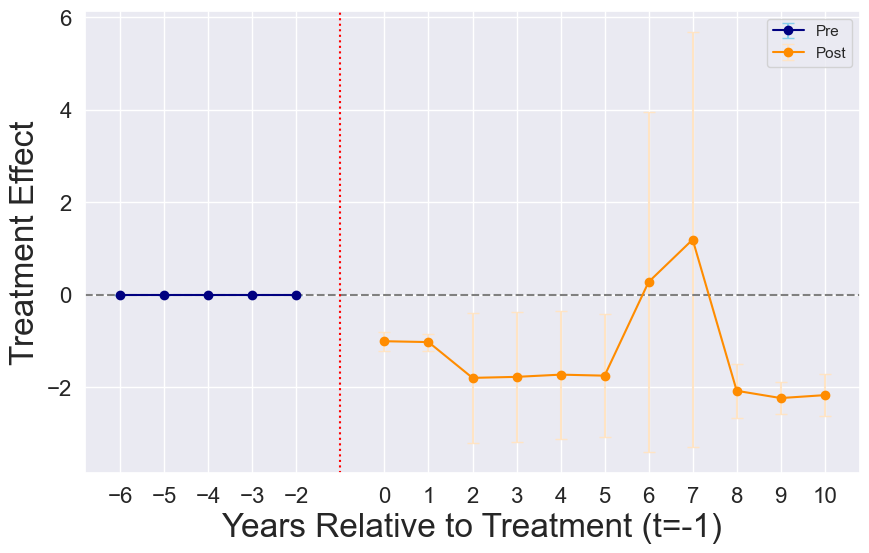

PTA F‐statistic: p‐value: nan
ATTᴼ = -1.4690, SE = 0.2990, p = 0.0000
Honest-DiD bounds: {'M=0.5': (-2.0550438177838197, -0.8830500757671744), 'M=1': (-2.0550438177838197, -0.8830500757671744), 'M=1.5': (-2.0550438177838197, -0.8830500757671744), 'M=2': (-2.0550438177838197, -0.8830500757671744)}
treated, control (16558, 132812)


9

In [16]:
import statsmodels.formula.api as smf
panel = create_event_time(df_subset, group_vars=["Country","CCUS_sector"], treatment_var="d_log_eor_capacity", time_var="Year")
panel.fillna(0)
pta_res = event_study_for_pta(
    panel,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)

panel.fillna(0)
plot_event_study(pta_res, save_path='event_study.png')
print(f"PTA F‐statistic: p‐value: {pta_res['p_value']:.3f}")
#pta = pretrend_test(panel, outcome='d_log_emissions', unit='Country', time='Year', treat='treated')
#print(f"Pre-trend F = {pta['F']:.2f}, p = {pta['p']:.3f}")
# 6. ATTᴼ estimation
att_res = att_o_estimator(
    panel,
    outcome_var="d_log_emissions",
    covariates=new_covariates,
    cluster_var="treatment_group"
)
print(f"ATTᴼ = {att_res['att_o']:.4f}, SE = {att_res['std_error']:.4f}, p = {att_res['p_value']:.4f}")
plt.show()
# 7. Honest DiD bounds
bounds = honest_did_bounds(pta_res, att_res['att_o'], att_res['std_error'])
print("Honest-DiD bounds:", bounds)
print('treated, control', count_treatment_status(panel))
panel["treatment_group"].nunique()

C:\Users\rjsou\Documents\PhD\Causal-CCUS\CausalCCUS\plotting.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Sector Trends with Policies'}, xlabel='Year', ylabel='Δ log Emissions'>

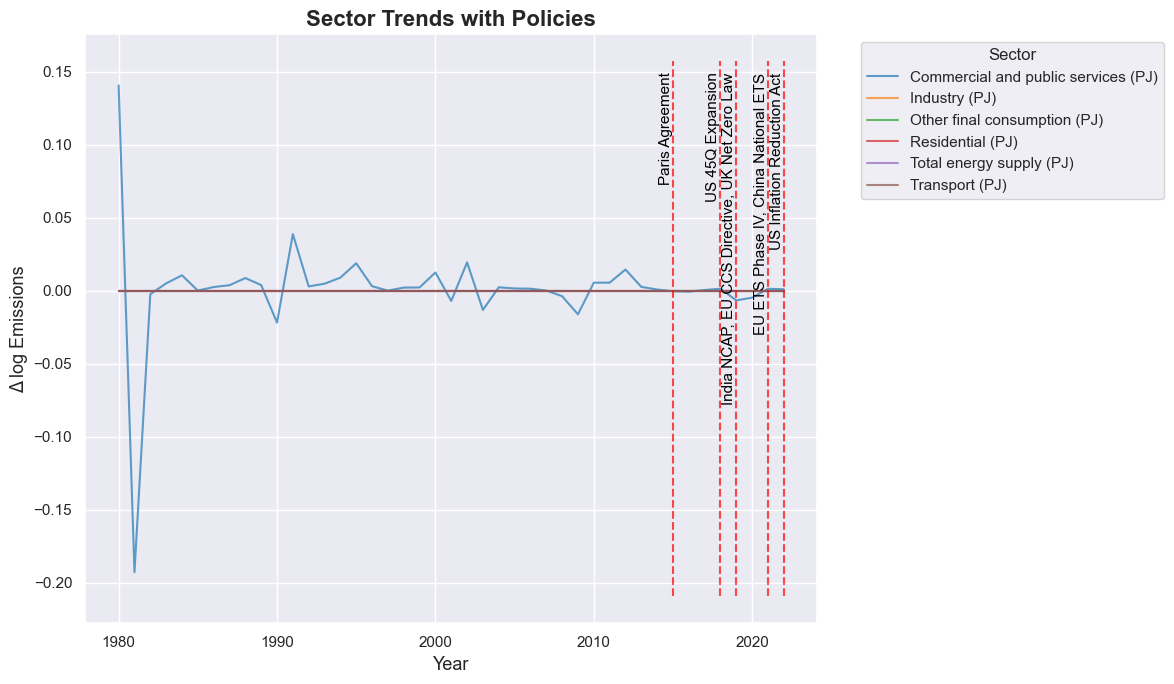

In [13]:
# 8. Policy‐timeline by sector
plot_by_sector_with_policies(
    panel,
    value_col="d_log_emissions",
    sector_col="Sector",
    year_col="Year",
    policy_dates=POLICY_DATES,
    ylabel="Δ log Emissions",
    title=None,
    save_file
)



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_raw_trends_with_ci(
    df,
    outcome_var="d_log_emissions",
    time_var="event_time",
    group_var="treated",
    event_window=(-6, 15),
    save_path=None
):
    """
    Overlay mean outcome for treated vs. control over event_time, with shaded 95% confidence intervals.
    The confidence intervals are computed as mean ± 1.96 × SE, where SE = std / sqrt(n) for each group-event_time cell.
    """
    # Filter the data to the event window
    plot_df = df[df[time_var].between(event_window[0], event_window[1])].copy()
    
    # Compute mean, count, std, se, CI for each group-time cell
    summary = (
        plot_df
        .groupby([time_var, group_var])[outcome_var]
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    summary['se'] = summary['std'] / np.sqrt(summary['count'])
    summary['lower_ci'] = summary['mean'] - 1.96 * summary['se']
    summary['upper_ci'] = summary['mean'] + 1.96 * summary['se']

    plt.figure(figsize=(10,6))
    colors = {0: ("navy", "skyblue"), 1: ("darkorange", "bisque")}
    # Plot line and CI for each group (treated/control)
    for g in summary[group_var].unique():
        data = summary[summary[group_var] == g]
        color = "navy" if g == 0 else "darkorange"
        label = "Control" if g == 0 else "Treated"
        group_data = summary[summary[group_var] == g]
        color, ecolor = colors.get(g, ("gray", "lightgray"))
        plt.errorbar(
            group_data[time_var],
            group_data['mean'],
            yerr=[group_data['mean'] - group_data['lower_ci'], group_data['upper_ci'] - group_data['mean']],
            fmt="o-", color=color, ecolor=ecolor, capsize=4, label=label
        )

    plt.axvline(-1, color='red', linestyle='--', alpha=0.7)
    plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
    plt.xlabel('Years Relative to Treatment (t=-1)', fontsize=16)
    plt.ylabel(outcome_var, fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.legend(fontsize=14)
    plt.title("Raw Trends with 95% Confidence Intervals", fontsize=18)
    #plt.tight_layout()
    if save_path:
        plt.savefig(
            f'Figures/Final/{save_path}'
            dpi=200,
            bbox_inches='tight'
        )
    plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (462863125.py, line 57)

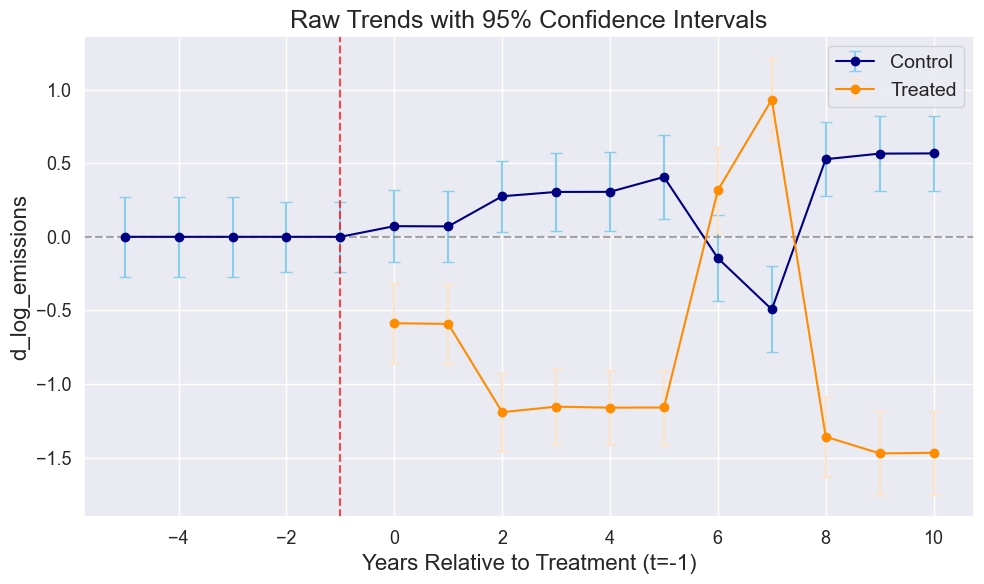

In [52]:
# 9. Raw‐trends overlay
plot_raw_trends_with_ci(panel, outcome_var="d_log_emissions", time_var="event_time",
                group_var="treated", event_window=(-5,10), save_path='treated_vs_untreated')

In [131]:
# enhanced_balance_report_with_cluster_counts.py

"""
Enhanced Balance Report and Cluster Counts for DiD Analysis
Generates summary statistics by Country×CCUS_Sector, treatment sparsity,
power (MDE), outcome variance, and prints cluster counts for different clustering dimensions.
"""

import pandas as pd
import numpy as np
from statsmodels.stats.power import TTestIndPower

def enhanced_balance_report(
    df: pd.DataFrame,
    treatment_var: str,
    outcome_var: str,
    group_vars: list[str]
) -> pd.DataFrame:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Panel dataset containing treatment indicator, outcome, and grouping vars.
    treatment_var : str
        Name of the binary treatment indicator (0/1).
    outcome_var : str
        Name of the outcome variable.
    group_vars : list[str]
        List of grouping variables for stratified summaries (e.g., ["Country", "CCUS_sector"]).
    
    Returns
    -------
    report_df : pd.DataFrame
        DataFrame summarizing for each group:
         - total_obs, treated_obs, control_obs, treat_prop
         - outcome_mean, outcome_sd
         - MDE_80_5 (minimum detectable effect, 80% power, α=5%)
    """
    results = []
    power_analysis = TTestIndPower()
    alpha, power = 0.05, 0.80

    # Group‐wise summaries
    grp = df.groupby(group_vars)
    for name, group in grp:
        total = len(group)
        treated = int(group[treatment_var].sum())
        control = total - treated
        prop = treated / total if total else np.nan

        y = group[outcome_var].dropna()
        mean_y, sd_y = y.mean(), y.std(ddof=1)

        # MDE calculation
        if treated > 1 and control > 1:
            mde = power_analysis.solve_power(
                effect_size=None,
                nobs1=treated,
                ratio=control/treated,
                alpha=alpha,
                power=power,
                alternative='two-sided'
            )
        else:
            mde = np.nan

        row = {**{gv: name[i] if isinstance(name, tuple) else name
                  for i, gv in enumerate(group_vars)},
               'total_obs': total,
               'treated_obs': treated,
               'control_obs': control,
               'treat_prop': round(prop, 3),
               'outcome_mean': round(mean_y, 3),
               'outcome_sd': round(sd_y, 3),
               'MDE_80_5': round(mde, 3) if not np.isnan(mde) else np.nan}
        results.append(row)

    report_df = pd.DataFrame(results)

    # Overall summary row
    overall = {
        'gv': ['Overall' for gv in group_vars],
        'total_obs': len(df),
        'treated_obs': int(df[treatment_var].sum()),
        'control_obs': int(len(df) - df[treatment_var].sum()),
        'treat_prop': round(df[treatment_var].mean(), 3),
        'outcome_mean': round(df[outcome_var].mean(), 3),
        'outcome_sd': round(df[outcome_var].std(ddof=1), 3),
        'MDE_80_5': round(
            power_analysis.solve_power(
                effect_size=None,
                nobs1=int(df[treatment_var].sum()),
                ratio=(len(df) - df[treatment_var].sum())/df[treatment_var].sum()
                if df[treatment_var].sum() > 0 else np.nan,
                alpha=alpha,
                power=power,
                alternative='two-sided'
            ), 3
        )
    }
    report_df = pd.concat([report_df, pd.DataFrame([overall])], ignore_index=True)
    return report_df


balance = enhanced_balance_report(
    df_subset,
    treatment_var='treated',
    outcome_var='d_log_emissions',
    group_vars=['Country', 'CCUS_sector']
)
print("\nBalance Report by Country × CCUS_sector:\n")
print(balance.to_string(index=False))

# Print cluster counts
n_country_clusters = df['Country'].nunique()
n_ccus_sector_clusters = df['CCUS_sector'].nunique()
df['country_ccussector'] = df['Country'] + "__" + df['CCUS_sector']
n_combined_clusters = df['country_ccussector'].nunique()

print(f"\nNumber of clusters when clustering by country only: {n_country_clusters}")
print(f"Number of clusters when clustering by CCUS_sector only: {n_ccus_sector_clusters}")
print(f"Number of clusters when two-way clustering by Country & CCUS_sector: {n_combined_clusters}")


KeyError: 'treated'

In [34]:
plot_cluster_cell_count_heatmap(panel, 'a').reset_index().index

RangeIndex(start=0, stop=6, step=1)

['-40', '-38', '-36', '-34', '-32', '-30', '-28', '-26', '-24', '-22', '-20', '-18', '-16', '-14', '-12', '-10', '-8', '-6', '-4', '-2', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32', '34', '36', '38', '40']


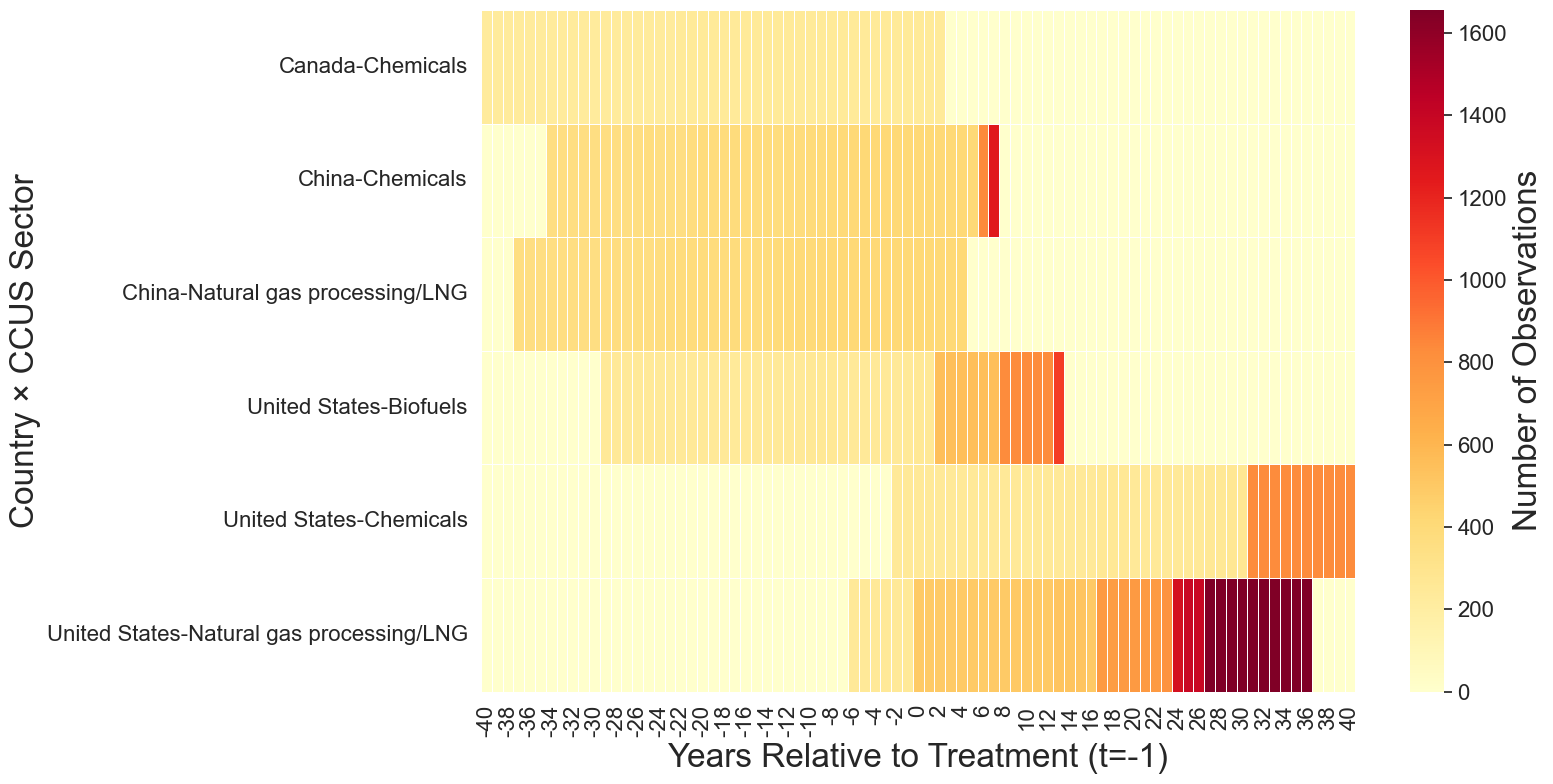

Figures/Final/cum_dist.png


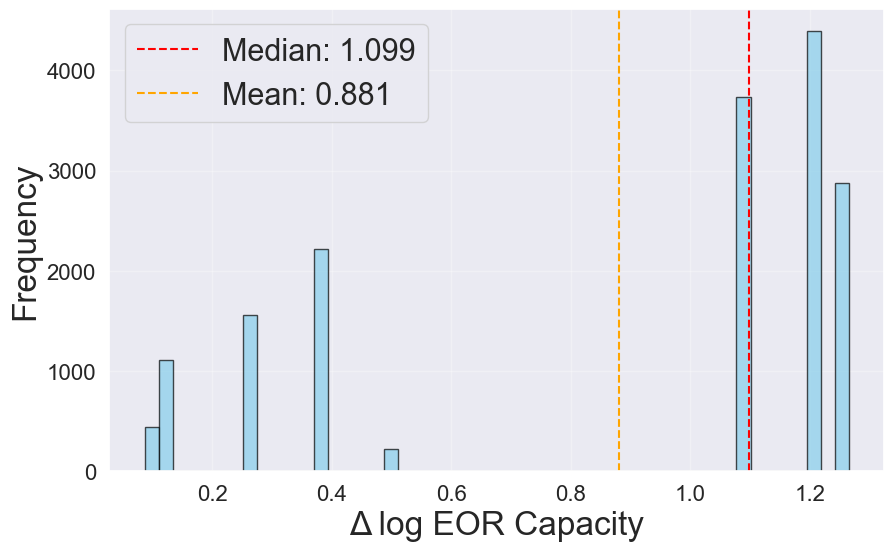

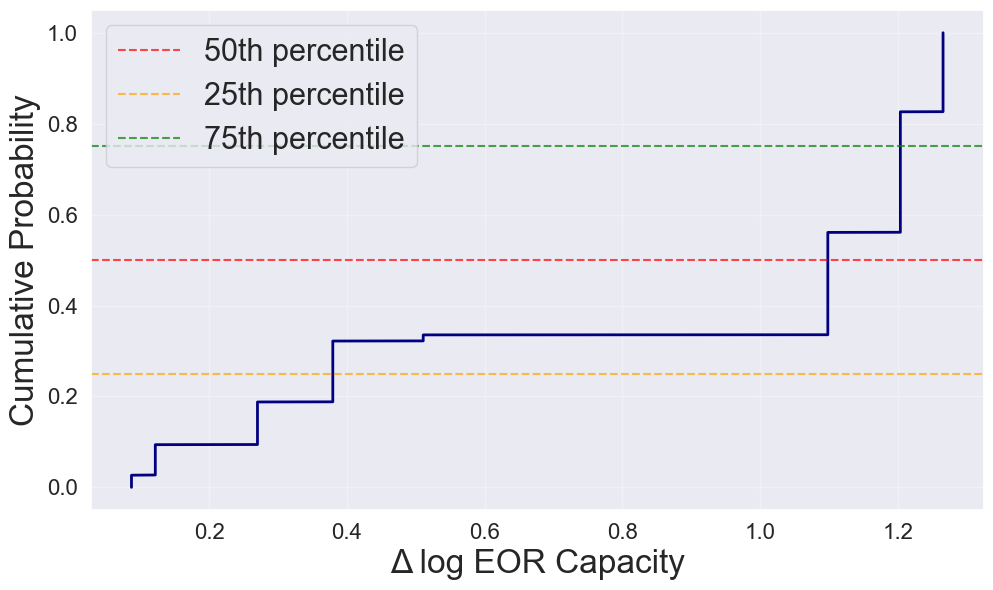

Treatment Intensity Distribution:
Number of treated observations: 16558
25th percentile: 0.379
50th percentile (median): 1.099
75th percentile: 1.204
Mean: 0.881
Standard deviation: 0.436
% of observations below median: 56.1%

Binary ATT^o Justification:
Concentration at low doses: 56.1% below median
⚠️  Consider continuous dose-response: More dispersed treatment distribution


KeyError: 'coefficient'

<Figure size 1000x600 with 0 Axes>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def plot_cluster_cell_count_heatmap(df, save_file):
    """
    Creates a heatmap showing observation counts by Country × CCUS_sector × event_time.

    Parameters:
    - df: DataFrame with columns ['Country', 'CCUS_sector', 'event_time']
    - save_file: Path to save the figure
    """
    # Compute observation counts
    cell_counts = (
        df.groupby(['event_time', 'Country', 'CCUS_sector'])
          .size()
          .reset_index(name='count')
    )

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    # Pivot for heatmap
    heatmap_data = cell_counts.pivot_table(
        index=['Country', 'CCUS_sector'],
        columns='event_time',
        values='count',
        fill_value=0
    )
    
    cax = sns.heatmap(
        heatmap_data,
        cmap='YlOrRd',
        annot=False,
        fmt='.0f',                     # Round floats to integers
        cbar_kws={'label': 'Number of Observations'},
        linewidths=0.5,
        ax=ax,
    )

    
    ticks = [item.get_text()[:-2] for item in ax.get_xticklabels()]
    print(ticks)
    ax.set_xticklabels([int(a) for a in ticks])

    cbar = ax.collections[0].colorbar
    cbar.set_label(label='Number of Observations', size=24) 
    cbar.ax.tick_params(labelsize=16)
    
    #ax.set_title('Cluster Cell Count Heat Map\n(Country × CCUS Sector × Event Time)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Years Relative to Treatment (t=-1)', fontsize=24)
    ax.set_ylabel('Country × CCUS Sector', fontsize=24)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    plt.show()


def plot_fossil_bio_event_study_overlay(df, save_file):
    """
    Creates overlay plot of event study coefficients for fossil vs bio units.
    
    Parameters:
    - df: DataFrame with event study results including 'fossil_bio', 'event_time', 
          'coefficient', 'conf_low', 'conf_high' columns
    - save_file: Path to save the figure
    """
    # Separate fossil and bio data
    fossil_data = df[df['fossil_bio'] == 1].copy()
    bio_data = df[df['fossil_bio'] == 0].copy()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot fossil coefficients
    plt.errorbar(
        fossil_data['event_time'], 
        fossil_data['coefficient'],
        yerr=[fossil_data['coefficient'] - fossil_data['conf_low'],
              fossil_data['conf_high'] - fossil_data['coefficient']],
        marker='o', 
        markersize=6,
        linewidth=2,
        capsize=4,
        label='Fossil CCUS',
        color='#d62728',  # Red
        alpha=0.8
    )
    
    # Plot bio coefficients
    plt.errorbar(
        bio_data['event_time'], 
        bio_data['coefficient'],
        yerr=[bio_data['coefficient'] - bio_data['conf_low'],
              bio_data['conf_high'] - bio_data['coefficient']],
        marker='s', 
        markersize=6,
        linewidth=2,
        capsize=4,
        label='Bio CCUS',
        color='#2ca02c',  # Green
        alpha=0.8
    )
    
    # Add horizontal line at zero
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add vertical line at treatment time
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1, 
                label='Treatment Start')
    
    # Formatting
    plt.xlabel('Years Relative to Treatment (t=-1)', fontsize=24)
    plt.ylabel('Treatment Effect', fontsize=24)
    #plt.title('Event Study: Fossil vs Bio CCUS Effects\n(Carbon Lock-in Analysis)', 
    #          fontsize=14, fontweight='bold')
    plt.legend(fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    plt.show()
    
    # Print analysis
    late_period_fossil = fossil_data[fossil_data['event_time'].between(6, 7)]
    late_period_bio = bio_data[bio_data['event_time'].between(6, 7)]
    
    if len(late_period_fossil) > 0 and len(late_period_bio) > 0:
        print("Carbon Lock-in Analysis (Years 6-7):")
        print(f"Fossil CCUS mean effect: {late_period_fossil['coefficient'].mean():.3f}")
        print(f"Bio CCUS mean effect: {late_period_bio['coefficient'].mean():.3f}")
        
        if late_period_fossil['coefficient'].mean() > late_period_bio['coefficient'].mean():
            print("⚠️  Potential carbon lock-in detected: Fossil effects less negative than Bio")
        else:
            print("✓ No clear carbon lock-in pattern detected")


def plot_dose_density_histogram(df, treatment_var='d_log_eor_capacity', save_file='dist.png'):
    """
    Creates histogram showing distribution of treatment intensity.
    
    Parameters:
    - df: DataFrame containing treatment variable
    - treatment_var: Name of continuous treatment variable
    - save_file: Path to save the figure
    """
    # Filter to treated units only (positive treatment)
    treated_data = df[df[treatment_var] > 0][treatment_var]
    
    # Create figure with subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sf = save_file
    save_file = sf + 'dist.png'
    # Histogram of all positive treatment values
    ax.hist(treated_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(treated_data.median(), color='red', linestyle='--', 
                label=f'Median: {treated_data.median():.3f}')
    ax.axvline(treated_data.mean(), color='orange', linestyle='--', 
                label=f'Mean: {treated_data.mean():.3f}')
    ax.set_xlabel('Δ log EOR Capacity', fontsize=24)
    ax.set_ylabel('Frequency', fontsize=24)
    #ax1.set_title('Distribution of Treatment Intensity\n(All Positive Values)', fontsize=12)
    ax.legend(fontsize=22)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    # Cumulative distribution
    sorted_data = np.sort(treated_data)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, cumulative, linewidth=2, color='navy')
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50th percentile')
    ax.axhline(y=0.25, color='orange', linestyle='--', alpha=0.7, label='25th percentile')
    ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.7, label='75th percentile')
    ax.set_xlabel('Δ log EOR Capacity', fontsize=24)
    ax.set_ylabel('Cumulative Probability', fontsize=24)
    #ax2.set_title('Cumulative Distribution of Treatment', fontsize=12)
    ax.legend(fontsize=22)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    save_file = sf + 'cum_dist.png'
    print(save_file)
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    
    # Print statistics
    q25, q50, q75 = treated_data.quantile([0.25, 0.5, 0.75])
    print("Treatment Intensity Distribution:")
    print(f"Number of treated observations: {len(treated_data)}")
    print(f"25th percentile: {q25:.3f}")
    print(f"50th percentile (median): {q50:.3f}")
    print(f"75th percentile: {q75:.3f}")
    print(f"Mean: {treated_data.mean():.3f}")
    print(f"Standard deviation: {treated_data.std():.3f}")
    print(f"% of observations below median: {(treated_data <= q50).mean()*100:.1f}%")
    
    # Justify binary choice
    low_dose_pct = (treated_data <= q50).mean() * 100
    print(f"\nBinary ATT^o Justification:")
    print(f"Concentration at low doses: {low_dose_pct:.1f}% below median")
    if low_dose_pct > 60:
        print("✓ Binary approach justified: Most observations at low treatment intensity")
    else:
        print("⚠️  Consider continuous dose-response: More dispersed treatment distribution")
        


def plot_placebo_treatment_distribution(df, treatment_var='d_log_eor_capacity', 
                                      outcome_var='d_log_emissions', 
                                      true_att=None, n_iterations=500, 
                                      save_file='placebo_distribution.png'):
    """
    Creates placebo test by randomizing treatment start dates.
    
    Parameters:
    - df: DataFrame with panel data
    - treatment_var: Name of treatment variable
    - outcome_var: Name of outcome variable  
    - true_att: True ATT^o estimate for comparison
    - n_iterations: Number of placebo iterations
    - save_file: Path to save the figure
    """
    import random
    from sklearn.linear_model import LinearRegression
    
    # Prepare data
    df_clean = df.dropna(subset=[treatment_var, outcome_var]).copy()
    
    # Get unique years for randomization
    years = sorted(df_clean['Year'].unique())
    treatment_years = years[5:-5]  # Avoid edge years
    
    placebo_effects = []
    
    print(f"Running {n_iterations} placebo iterations...")
    
    for i in range(n_iterations):
        if i % 100 == 0:
            print(f"Iteration {i}/{n_iterations}")
            
        # Randomly assign treatment year
        random_year = random.choice(treatment_years)
        
        # Create placebo treatment
        df_placebo = df_clean.copy()
        df_placebo['placebo_treated'] = (
            (df_placebo['Year'] >= random_year) & 
            (df_placebo[treatment_var] > 0)
        ).astype(int)
        
        # Estimate placebo ATT^o
        try:
            X = df_placebo[['placebo_treated']].values
            y = df_placebo[outcome_var].values
            
            # Simple OLS for placebo effect
            reg = LinearRegression().fit(X, y)
            placebo_att = reg.coef_[0]
            placebo_effects.append(placebo_att)
            
        except:
            continue
    
    placebo_effects = np.array(placebo_effects)
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot histogram of placebo effects
    plt.hist(placebo_effects, bins=50, alpha=0.7, density=True, 
             color='lightblue', edgecolor='black', label='Placebo Distribution')
    
    # Add true effect if provided
    if true_att is not None:
        plt.axvline(true_att, color='red', linewidth=3, 
                   label=f'True ATT^o = {true_att:.3f}')
        
        # Calculate p-value
        p_value = (np.abs(placebo_effects) >= np.abs(true_att)).mean()
        plt.text(0.05, 0.95, f'Placebo p-value: {p_value:.4f}', 
                transform=plt.gca().transAxes, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add normal distribution overlay
    mu, sigma = placebo_effects.mean(), placebo_effects.std()
    x = np.linspace(placebo_effects.min(), placebo_effects.max(), 100)
    normal_dist = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, normal_dist, 'k--', linewidth=2, alpha=0.7, 
             label=f'Normal (μ={mu:.3f}, σ={sigma:.3f})')
    
    # Formatting
    plt.xlabel('Placebo ATT^o Estimate', fontsize=24)
    plt.ylabel('Density', fontsize=24)
    #plt.title(f'Placebo Treatment Distribution\n({len(placebo_effects)} iterations)', 
    #          fontsize=14, fontweight='bold')
    plt.legend(fontsize=22)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.tick_params(axis='both', which='major', labelsize=14)

    # Save figure
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    plt.show()
    
    # Print results
    print(f"\nPlacebo Test Results:")
    print(f"Number of iterations: {len(placebo_effects)}")
    print(f"Mean placebo effect: {placebo_effects.mean():.4f}")
    print(f"Standard deviation: {placebo_effects.std():.4f}")
    print(f"95% confidence interval: [{np.percentile(placebo_effects, 2.5):.3f}, {np.percentile(placebo_effects, 97.5):.3f}]")
    
    if true_att is not None:
        percentile = (placebo_effects <= true_att).mean() * 100
        print(f"True effect percentile: {percentile:.1f}%")
        if percentile > 95 or percentile < 5:
            print("✓ True effect in extreme tail - strong evidence of causal effect")
        else:
            print("⚠️  True effect not in extreme tail - weaker evidence")


# Example usage functions
def run_all_diagnostics(df, save_dir='Figures/Final/'):
    """
    Convenience function to run all diagnostic plots.
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Cluster cell count heatmap
    plot_cluster_cell_count_heatmap(df, f'{save_dir}cluster_cell_count.png')
    
    # 2. Dose density histogram
    plot_dose_density_histogram(df, save_file=f'{save_dir}')
    
    # 3. Placebo distribution (if true ATT available)
    # plot_placebo_treatment_distribution(df, true_att=-1.705, save_file=f'{save_dir}placebo_dist.png')
    plot_fossil_bio_event_study_overlay(df, save_file=f'{save_dir}overlay.png')
    print("All diagnostic plots completed!")
run_all_diagnostics(panel)

In [57]:
import pandas as pd

# Assuming your panel DataFrame is named `panel`
ct = pd.crosstab(panel['CCUS_sector'], panel['fossil_bio'])
print(ct)


fossil_bio                    bio  fossil
CCUS_sector                              
Biofuels                     6840   35898
Chemicals                    7134   37140
Natural gas processing/LNG  10632   51726


In [82]:
df_subset['emissions_sector'].unique()

array(['Biological Treatment of Solid Waste', 'Cement production',
       'Chemical Industry', 'Civil Aviation',
       'Direct N2O Emissions from managed soils', 'Electronics Industry',
       'Emissions from biomass burning', 'Enteric Fermentation',
       'Glass Production', 'Incineration and Open Burning of Waste',
       'Indirect N2O Emissions from managed soils',
       'Indirect N2O Emissions from manure management',
       'Indirect N2O emissions from the atmospheric deposition of nitrogen in NOx and NH3',
       'Lime production', 'Liming',
       'Main Activity Electricity and Heat Production',
       'Manufacturing Industries and Construction', 'Manure Management',
       'Metal Industry', 'Non-Energy Products from Fuels and Solvent Use',
       'Oil and Natural Gas', 'Other Process Uses of Carbonates',
       'Other Product Manufacture and Use', 'Other Transportation',
       'Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries',
       'Product Use

In [90]:
df_subset['CCUS_sector'].value_counts()

CCUS_sector
Natural gas processing/LNG    62358
Chemicals                     44274
Biofuels                      42738
Name: count, dtype: int64

In [7]:
def extract_event_coefs(pta_res):
    params = pta_res['model'].params
    cis    = pta_res['model'].conf_int()
    rows = []
    for term in pta_res['interaction_terms']:
        if term not in params.index:
            continue
        coef = params[term]
        lo, hi = cis.loc[term]
        suffix = term.replace('event_','').replace('_treated','')
        t = -int(suffix[1:]) if suffix.startswith('m') else int(suffix)
        rows.append((t, coef, lo, hi))
    return pd.DataFrame(rows, columns=['event_time','coefficient','conf_low','conf_high'])

# Subgroup analysis

Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40

 WasteBiomass

-----------
Using: d_log_emissions with ['d_Demand_electricity', 'd_Demand_heat', 'd_Demand_nuclear', 'd_Demand_renewables_and_waste', 'd_Supply_nuclear', 'd_energy_demand_fossil_fuels', 'd_CPI_growth', 'd_GDP_per_capita_PPP', 'd_renewable_to_fossil_supply_ratio']
-------------
    ATT^o = -1.1221 (SE=0.3213, p=0.0005)
    Honest-DiD bounds WasteBiomass: {'M=0.5': (-1.75172570623694, -0.4924065527193813), 'M=1': (-1.75172570623694, -0.4924065527193813), 'M=1.5': (-1.75172570623694, -0.4924065527193813), 'M=2': (-1.75172570623694, -0.4924065527193813)}
    WasteBiomass PTA p-value: nan
Custers 9

Units: treated=2254, control=19388

 IndustryManufacturing

-----------
Using: d_log_emissions with ['d_Demand_electricity', 'd_Demand_heat', 'd_Demand_nuclear', 'd_Demand_renewables_and_waste', 'd_Supply_nuclear', 'd_energy_demand_fossil_fuels', 'd_CPI_growth', 

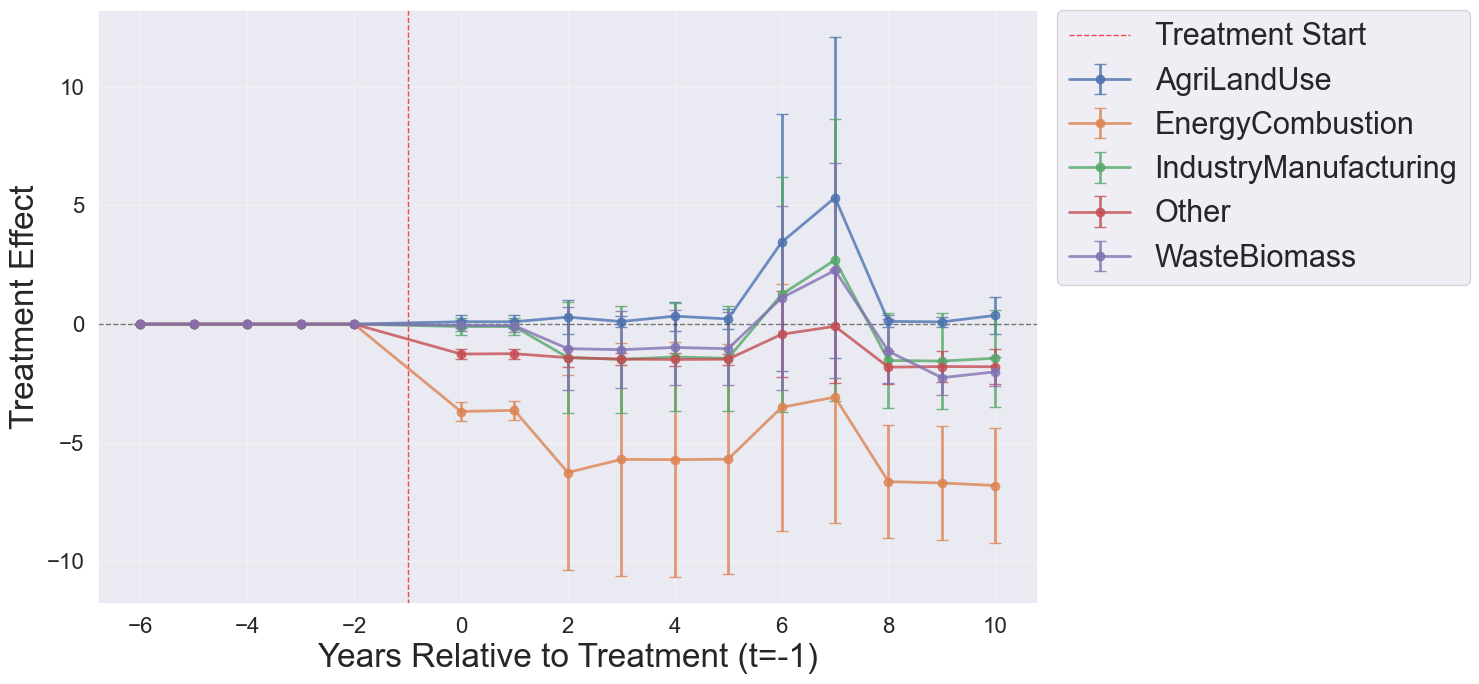


Pooled ATT^o = -1.4540 (SE=0.1487, p=0.0000)
Weights: High={'WasteBiomass': 0.1361275516366711, 'IndustryManufacturing': 0.1630631718806619, 'EnergyCombustion': 0.13588597656721826, 'AgriLandUse': 0.19024036719410556, 'Other': 0.3746829327213432}


In [13]:
import pandas as pd

# 1. Map detailed emissions_sector to four broad groups
sector_map = {
    "EnergyCombustion": [
        "Main Activity Electricity and Heat Production",
        "Road Transportation no resuspension",
        "Civil Aviation",
        "Railways",
        "Water-borne Navigation"
    ],
    "IndustryManufacturing": [
        "Cement production",
        "Chemical Industry",
        "Glass Production",
        "Metal Industry",
        "Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries",
        "Non-Energy Products from Fuels and Solvent Use"
    ],
    "AgriLandUse": [
        "Enteric Fermentation",
        "Rice cultivations",
        "Manure Management",
        "Direct N2O Emissions from managed soils",
        "Indirect N2O Emissions from managed soils",
        "Indirect N2O Emissions from manure management",
        "Indirect N2O emissions from the atmospheric deposition of nitrogen in NOx and NH3"
    ],
    "WasteBiomass": [
        "Biological Treatment of Solid Waste",
        "Solid Waste Disposal",
        "Incineration and Open Burning of Waste",
        "Emissions from biomass burning",
        "Wastewater Treatment and Discharge"
    ]
}

import matplotlib.pyplot as plt

def pool_n_cohort_att_o_estimates(cohort_data, 
                                  att_col='att_o', 
                                  se_col='se', 
                                  n_treated_col='n_treated',
                                  cohort_id_col='cohort_id'):
    """
    Pool n cohort ATT^o estimates using exposure-probability weights 
    per Callaway et al. (2024), and return pooled estimate, SE, and p-value.
    
    Parameters
    ----------
    cohort_data : list of dict, pandas.DataFrame, or dict of arrays
        Cohort data where each element/row contains:
        - ATT^o estimate for the cohort
        - Standard error for cohort ATT^o  
        - Number of treated units in cohort
        - Cohort identifier (optional)
    att_col : str, default 'att_o'
        Column name for ATT^o estimates
    se_col : str, default 'se'  
        Column name for standard errors
    n_treated_col : str, default 'n_treated'
        Column name for number of treated units per cohort
    cohort_id_col : str, default 'cohort_id'
        Column name for cohort identifiers
        
    Returns
    -------
    results : dict
        Dictionary containing:
        - 'pooled_att': Pooled ATT^o estimate using exposure-probability weights
        - 'pooled_se': Standard error of pooled ATT^o via delta method
        - 'pooled_p': Two-sided p-value for pooled ATT^o estimate
        - 'weights': Dictionary mapping cohort_id to exposure-probability weights
        - 'cohort_summary': DataFrame with individual cohort results and weights
        
    Examples
    --------
    # With list of dictionaries
    cohort_data = [
        {'att_o': -1.5, 'se': 0.3, 'n_treated': 100, 'cohort_id': 'fossil'},
        {'att_o': -0.8, 'se': 0.5, 'n_treated': 50, 'cohort_id': 'bio'}, 
        {'att_o': -2.1, 'se': 0.4, 'n_treated': 75, 'cohort_id': 'industrial'}
    ]
    results = pool_n_cohort_att_o_estimates(cohort_data)
    
    # With pandas DataFrame and custom column names
    df = pd.DataFrame({
        'treatment_effect': [-1.2, -0.9, -1.8],
        'std_error': [0.25, 0.4, 0.35], 
        'treated_count': [80, 60, 120],
        'year': ['2010', '2015', '2020']
    })
    results = pool_n_cohort_att_o_estimates(
        df, 
        att_col='treatment_effect',
        se_col='std_error',
        n_treated_col='treated_count', 
        cohort_id_col='year'
    )
    """
    import numpy as np
    import scipy.stats as stats
    import pandas as pd
    
    # Convert input to DataFrame
    if isinstance(cohort_data, dict):
        df = pd.DataFrame(cohort_data)
    elif isinstance(cohort_data, list):
        df = pd.DataFrame(cohort_data)
    else:
        df = cohort_data.copy()
    
    # Rename columns to standard names if different
    column_mapping = {
        att_col: 'att_o',
        se_col: 'se', 
        n_treated_col: 'n_treated'
    }
    
    if cohort_id_col in df.columns:
        column_mapping[cohort_id_col] = 'cohort_id'
    
    df = df.rename(columns=column_mapping)
    
    # Add cohort_id if not present
    if 'cohort_id' not in df.columns:
        df['cohort_id'] = [f'cohort_{i}' for i in range(len(df))]
    
    # Validate required columns
    required_cols = ['att_o', 'se', 'n_treated']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Remove rows with missing values
    df_clean = df.dropna(subset=required_cols).copy()
    
    if len(df_clean) == 0:
        raise ValueError("No valid cohort data after removing missing values")
    
    # Calculate exposure-probability weights: w_g = n_treated_g / sum(n_treated_h)
    total_treated = df_clean['n_treated'].sum()
    df_clean['weight'] = df_clean['n_treated'] / total_treated
    
    # Pooled ATT^o estimate: sum(w_g * ATT_g)
    pooled_att = (df_clean['weight'] * df_clean['att_o']).sum()
    
    # Delta-method variance: Var(sum w_g * ATT_g) = sum(w_g^2 * SE_g^2)
    pooled_var = (df_clean['weight']**2 * df_clean['se']**2).sum()
    pooled_se = np.sqrt(pooled_var)
    
    # Two-sided p-value (t-test against null of zero effect)
    # Use conservative df = min(n_treated across cohorts) - 1
    df_conservative = df_clean['n_treated'].min() - 1
    if pooled_se > 0:
        t_stat = pooled_att / pooled_se
        pooled_p = 2 * (1 - stats.t.cdf(abs(t_stat), df=max(df_conservative, 1)))
    else:
        pooled_p = np.nan
    
    # Create weights dictionary
    weights = dict(zip(df_clean['cohort_id'], df_clean['weight']))
    
    # Summary DataFrame
    cohort_summary = df_clean[['cohort_id', 'att_o', 'se', 'n_treated', 'weight']].copy()
    
    results = {
        'pooled_att': pooled_att,
        'pooled_se': pooled_se, 
        'pooled_p': pooled_p,
        'weights': weights,
        'cohort_summary': cohort_summary
    }
    
    return results



def plot_event_study_overlay_by_group(df, group_col, save_file, two_colors=True):
    """
    Creates an overlay plot of event-study coefficients for multiple subgroups    Parameters:
    - df: pandas DataFrame with columns:
        • group_col: subgroup identifier (e.g. 'sector_group', 'CCUS_sector_fossil', etc.)
        • 'event_time': integer years relative to treatment
        • 'coefficient': estimated effect at each event time
        • 'conf_low': lower bound of 95% confidence interval
        • 'conf_high': upper bound of 95% confidence interval
    - group_col: string, name of the column defining subgroups
    - save_file: string file path to save the resulting figure (e.g. 'overlay_by_group.png')
    """
    plt.figure(figsize=(15, 7))

    colors = ['green', 'red', 'green']
    def create_dict_from_kwargs(**kwargs):
        return kwargs
        
    for i, (grp, grp_df) in enumerate( df.groupby(group_col)):
        grp_df = grp_df.sort_values('event_time')
        kwargs = {
            'x':      grp_df['event_time'],
            'y':      grp_df['coefficient'],
            'yerr': [
                grp_df['coefficient'] - grp_df['conf_low'],
                grp_df['conf_high']   - grp_df['coefficient']
            ],
            'marker':     'o',
            'markersize': 6,
            'linewidth':  2,
            'capsize':    4,
            'label':      grp,
            'alpha':      0.8,
        }


        if two_colors:
            kwargs['color'] = colors[i]
        plt.errorbar(
            **kwargs
        )

    # Horizontal zero line
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    # Vertical treatment line
    plt.axvline(-1, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Treatment Start')

    plt.xlabel('Years Relative to Treatment (t=-1)', fontsize=24)
    plt.ylabel('Treatment Effect', fontsize=24)
    plt.legend(title='', fontsize=22,
               loc='upper left',
               bbox_to_anchor=(1.02, 1),
               borderaxespad=0)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    plt.show()



# Assign group or Other
df_subset["sector_group"] = (
    df_subset["emissions_sector"]
    .map({s: g for g, lst in sector_map.items() for s in lst})
    .fillna("Other")
)

# 2. Create panel with event_time
panel = create_event_time(
    df_subset,
    group_vars=["Country","CCUS_sector"],
    treatment_var="d_log_eor_capacity",
    time_var="Year"
)

# 3. Run pooled event‐study with sector_group interactions
res = event_study_for_pta(
    panel,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)

# 4. Extract base and subgroup lags/lags × sector_group terms
base_coefs = extract_event_coefs(res)
base_coefs["sector_group"] = "All"

res_dicts = []
subgroup_coefs = []
for grp in panel["sector_group"].unique():
    sub_panel = panel[panel["sector_group"] == grp].copy()
    res_dicts.append(run_study_single(sub_panel, grp))
    sub_res = event_study_for_pta(
        sub_panel,                # <- use the restricted data
        outcome_var="d_log_emissions",
        treatment_var="d_log_eor_capacity",
        event_time_var="event_time",
        covariates=analytic_vars,
        cluster_var="treatment_group",
        pre_window=6,
        post_window=10,
        fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
    )
    dfc = extract_event_coefs(sub_res)
    dfc["sector_group"] = grp
    
    subgroup_coefs.append(dfc)

overlay_df = pd.concat(subgroup_coefs, ignore_index=True)

# 5. Plot
plot_event_study_overlay_by_group(
    overlay_df,
    #save_file=None,
    group_col='sector_group',
    save_file='mapped_group_event.png',
    two_colors=False
)

# After calculating high_att, high_se, low_att, low_se for each subgroup

results = pool_n_cohort_att_o_estimates(res_dicts)

print(f"\nPooled ATT^o = {results['pooled_att']:.4f} (SE={results['pooled_se']:.4f}, p={results['pooled_p']:.4f})")
print(f"Weights: High={results['weights']}")

In [10]:
import numpy as np

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_event_study_overlay_by_fossil_bio(overlay_df: pd.DataFrame, save_file: str):
    """
    Creates an overlay event-study plot comparing fossil vs. bio CCUS dynamics.
    
    Parameters:
    - overlay_df: DataFrame containing columns:
        • 'event_time': integer years relative to treatment
        • 'coefficient': estimated event-study coefficient at each event_time
        • 'conf_low': lower bound of 95% confidence interval
        • 'conf_high': upper bound of 95% confidence interval
        • 'fossil_bio': subgroup indicator (1 for fossil-derived emissions, 0 for bio-derived)
    - save_file: File path (including filename.png) to save the figure.
    """
    # Separate fossil and bio data
    fossil_df = overlay_df[overlay_df['fossil_bio'] == 1]
    bio_df    = overlay_df[overlay_df['fossil_bio'] == 0]
    
    plt.figure(figsize=(10, 6))
    
    # Plot fossil subgroup
    plt.errorbar(
        fossil_df['event_time'],
        fossil_df['coefficient'],
        yerr=[
            fossil_df['coefficient'] - fossil_df['conf_low'],
            fossil_df['conf_high'] - fossil_df['coefficient']
        ],
        marker='o',
        markersize=6,
        linewidth=2,
        capsize=4,
        label='Fossil',
        color='red',
        alpha=0.8
    )
    
    # Plot bio subgroup
    plt.errorbar(
        bio_df['event_time'],
        bio_df['coefficient'],
        yerr=[
            bio_df['coefficient'] - bio_df['conf_low'],
            bio_df['conf_high'] - bio_df['coefficient']
        ],
        marker='s',
        markersize=6,
        linewidth=2,
        capsize=4,
        label='Bio',
        color='green',
        alpha=0.8
    )
    
    # Vertical and horizontal reference lines
    plt.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(-1, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Treatment year')
    
    # Formatting
    plt.xlabel('Years relative to treatment (t=-1)', fontsize=24)
    plt.ylabel('Treatment Effect', fontsize=24)
    #plt.title('Event-Study Overlay: Fossil vs. Bio Emissions Subgroups', fontsize=14, fontweight='bold')
    plt.legend(title='', fontsize=22)
    plt.grid(alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    
    # Save and display
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    plt.show()


Preprocessing completed...
Treated units: 12628
Control units: 112136
Treatment groups: 9
Event time range: -40 to 40
Preprocessing completed...
Treated units: 3930
Control units: 20676
Treatment groups: 9
Event time range: -40 to 36


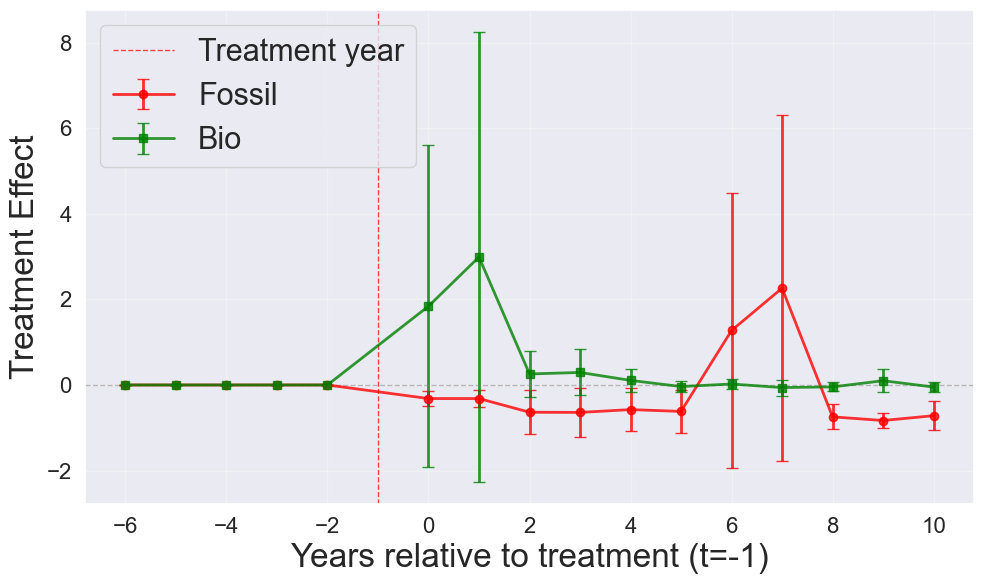


bio ATT^o = -0.9713 (SE=0.3178, p=0.0022)
fossil ATT^o = -0.9612 (SE=0.4084, p=0.0186)

Honest-DiD bounds bio: {'M=0.5': (-1.5941362394639702, -0.34853341734373855), 'M=1': (-1.5941362394639702, -0.34853341734373855), 'M=1.5': (-1.5941362394639702, -0.34853341734373855), 'M=2': (-1.5941362394639702, -0.34853341734373855)}
Honest-DiD bounds fossil: {'M=0.5': (-1.7616158826755495, -0.16071197031845796), 'M=1': (-1.7616158826755495, -0.16071197031845796), 'M=1.5': (-1.7616158826755495, -0.16071197031845796), 'M=2': (-1.7616158826755495, -0.16071197031845796)}

bio PTA p-value: nan
fossil PTA p-value: nan

Pooled ATT^o = -0.9636 (SE=0.3205, p=0.0027)
Weights: High=0.237, Low=0.763
  Difference = -0.0102 (SE=0.5174, p=0.9848)
High clusters 9
Low clusters 9

High cohort units: treated=3930, control=20676
Low  cohort units: treated=12628,  control=112136


In [146]:
# 2. Create event‐time panels
panel_fossil = create_event_time(
    df_subset[df_subset['fossil_bio']=='fossil'],
    group_vars=["Country","CCUS_sector"],
    treatment_var="d_log_eor_capacity",
    time_var="Year"
)

panel_bio = create_event_time(
    df_subset[df_subset['fossil_bio']=='bio'],
    group_vars=["Country","CCUS_sector"],
    treatment_var="d_log_eor_capacity",
    time_var="Year"
)

# 3. Run PTA event‐study on each sub‐sample
pta_res_fossil = event_study_for_pta(
    panel_fossil,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)
pta_res_bio = event_study_for_pta(
    panel_bio,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)

# 4. Extract and label coefficients
df_fossil_coefs = extract_event_coefs(pta_res_fossil)
df_fossil_coefs['fossil_bio'] = 1
df_bio_coefs    = extract_event_coefs(pta_res_bio)
df_bio_coefs['fossil_bio']    = 0

overlay_df = pd.concat([df_fossil_coefs, df_bio_coefs], ignore_index=True)

# 5. Plot
plot_event_study_overlay_by_fossil_bio(overlay_df, "Figures/Final/subgroup_fossil_bio.png")
run_study(panel_bio, panel_fossil, 'bio', 'fossil')

In [148]:
analytic_vars

['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP',
 'renewable_to_fossil_supply_ratio']

In [5]:
def run_study_single(panel1, name1, cov1=analytic_vars, cov2=new_covariates, outcome='d_log_emissions'):
    # 3. Run event-study on each subsample
    pta1 = event_study_for_pta(
        panel1,
        outcome_var=outcome,
        treatment_var="d_log_eor_capacity",
        event_time_var="event_time",
        covariates=cov1,
        cluster_var="treatment_group",
        pre_window=6,
        post_window=10,
        fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
    )
    print('\n', name1)

    print('\n-----------')
    print(f'Using: {outcome} with {cov2}')
    print('-------------')

    res_dict = att_o_estimator(
        panel1, outcome, 'd_log_eor_capacity', cov2, 'treatment_group'
    )
    att_high, se_high, p_high = res_dict['att_o'], res_dict['std_error'], res_dict['p_value']

    
    print(f"    ATT^o = {att_high:.4f} (SE={se_high:.4f}, p={p_high:.4f})")

    bounds = honest_did_bounds(pta1, att_high, se_high)
    print(f"    Honest-DiD bounds {name1}:", bounds)

    print(f"    {name1} PTA p-value: {pta1['p_value']:.3f}")
    

    high_treated, high_control = count_treatment_status(panel1)

    n_clusters_high = panel1["treatment_group"].nunique()
    print('Custers', n_clusters_high)

    print(f"\nUnits: treated={high_treated}, control={high_control}")

    return {
        'att_o': att_high,
        'se': se_high,
        'cohort_id': name1,
        'n_treated': high_treated,
        'p_val': p_high
    }
        

In [6]:
def run_study(panel1, panel2, name1, name2, cov1=analytic_vars, cov2=new_covariates, outcome='d_log_emissions'):
    # 3. Run event-study on each subsample
    pta1 = event_study_for_pta(
        panel1,
        outcome_var=outcome,
        treatment_var="d_log_eor_capacity",
        event_time_var="event_time",
        covariates=cov1,
        cluster_var="treatment_group",
        pre_window=6,
        post_window=10,
        fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
    )
    pta2 = event_study_for_pta(
        panel2,
        outcome_var=outcome,
        treatment_var="d_log_eor_capacity",
        event_time_var="event_time",
        covariates=cov1,
        cluster_var="treatment_group",
        pre_window=6,
        post_window=10,
        fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
    )

    """print('\n-----------')
    print(f'Using: {outcome} with {cov2}')
    print'-------------)"""
    res_dict =res_dict = att_o_estimator(
        panel1, outcome, 'd_log_eor_capacity', cov2, 'treatment_group'
    )
    att_high, se_high, p_high = res_dict['att_o'], res_dict['std_error'], res_dict['p_value']

    res_dict = res_dict = att_o_estimator(
        panel2, outcome, 'd_log_eor_capacity', cov2, 'treatment_group'
    )
    att_low, se_low, p_low = res_dict['att_o'], res_dict['std_error'], res_dict['p_value']

    print(f"\n{name1} ATT^o = {att_high:.4f} (SE={se_high:.4f}, p={p_high:.4f})")
    print(f"{name2} ATT^o = {att_low:.4f} (SE={se_low:.4f}, p={p_low:.4f})")

    bounds = honest_did_bounds(pta1, att_high, se_high)
    print(f"\nHonest-DiD bounds {name1}:", bounds)
    bounds = honest_did_bounds(pta2, att_low, se_low)
    print(f"Honest-DiD bounds {name2}:", bounds)

    print(f"\n{name1} PTA p-value: {pta1['p_value']:.3f}")
    print(f"{name2} PTA p-value: {pta2['p_value']:.3f}")
    
    # After calculating high_att, high_se, low_att, low_se for each subgroup
    pooled_att, pooled_se, pooled_p, weights = pool_cohort_att_o_estimates(
        high_att=att_high, 
        low_att=att_low,
        high_se=se_high, 
        low_se=se_low,
        high_n_treated=len(panel1[panel1['treated']==1]),  # Count treated units in high cohort
        low_n_treated=len(panel2[panel2['treated']==1])      # Count treated units in low cohort
    )
    
    print(f"\nPooled ATT^o = {pooled_att:.4f} (SE={pooled_se:.4f}, p={pooled_p:.4f})")
    print(f"Weights: High={weights['high']:.3f}, Low={weights['low']:.3f}")
    

    

    # Simple diff‐in‐SE t‐test
    diff = att_high - att_low
    se_diff = np.sqrt(se_high**2 + se_low**2)
    t_stat = diff / se_diff
    #dfree = max(min(len(high_df), len(low_df)) - 2, 1)
    n_clusters_high = panel1["treatment_group"].nunique()
    n_clusters_low = panel2["treatment_group"].nunique()
    dfree = max(min(n_clusters_high, n_clusters_low) - 1, 1)
    p_diff = 2 * (1 - stats.t.cdf(abs(t_stat), df=dfree))

    
    print(f"  Difference = {diff:.4f} (SE={se_diff:.4f}, p={p_diff:.4f})")

    print('High clusters', n_clusters_high)
    print('Low clusters', n_clusters_low)
    high_treated, high_control = count_treatment_status(panel1)
    low_treated,  low_control  = count_treatment_status(panel2)

    print(f"\nHigh cohort units: treated={high_treated}, control={high_control}")
    print(f"Low  cohort units: treated={low_treated},  control={low_control}")
        

In [45]:
fes = ['treatment_group', 'Sector', 'emissions_sector', 'Year']

for fe in fes:
    counts = panel_bio.groupby(fe)['log_R2F'].nunique()
    print('\n', fe, counts[counts <= 1])



 treatment_group Series([], Name: log_R2F, dtype: int64)

 Sector Series([], Name: log_R2F, dtype: int64)

 emissions_sector Series([], Name: log_R2F, dtype: int64)

 Year Series([], Name: log_R2F, dtype: int64)


In [47]:
panel['treatment_group']

0                                  Canada_Biofuels
1                                  Canada_Biofuels
2                                  Canada_Biofuels
3                                  Canada_Biofuels
4                                  Canada_Biofuels
                            ...                   
149365    United States_Natural gas processing/LNG
149366    United States_Natural gas processing/LNG
149367    United States_Natural gas processing/LNG
149368    United States_Natural gas processing/LNG
149369    United States_Natural gas processing/LNG
Name: treatment_group, Length: 149370, dtype: object

Preprocessing completed...
Treated units: 2889
Control units: 41385
Treatment groups: 3
Event time range: -40 to 40
Preprocessing completed...
Treated units: 13669
Control units: 91427
Treatment groups: 6
Event time range: -37 to 36


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


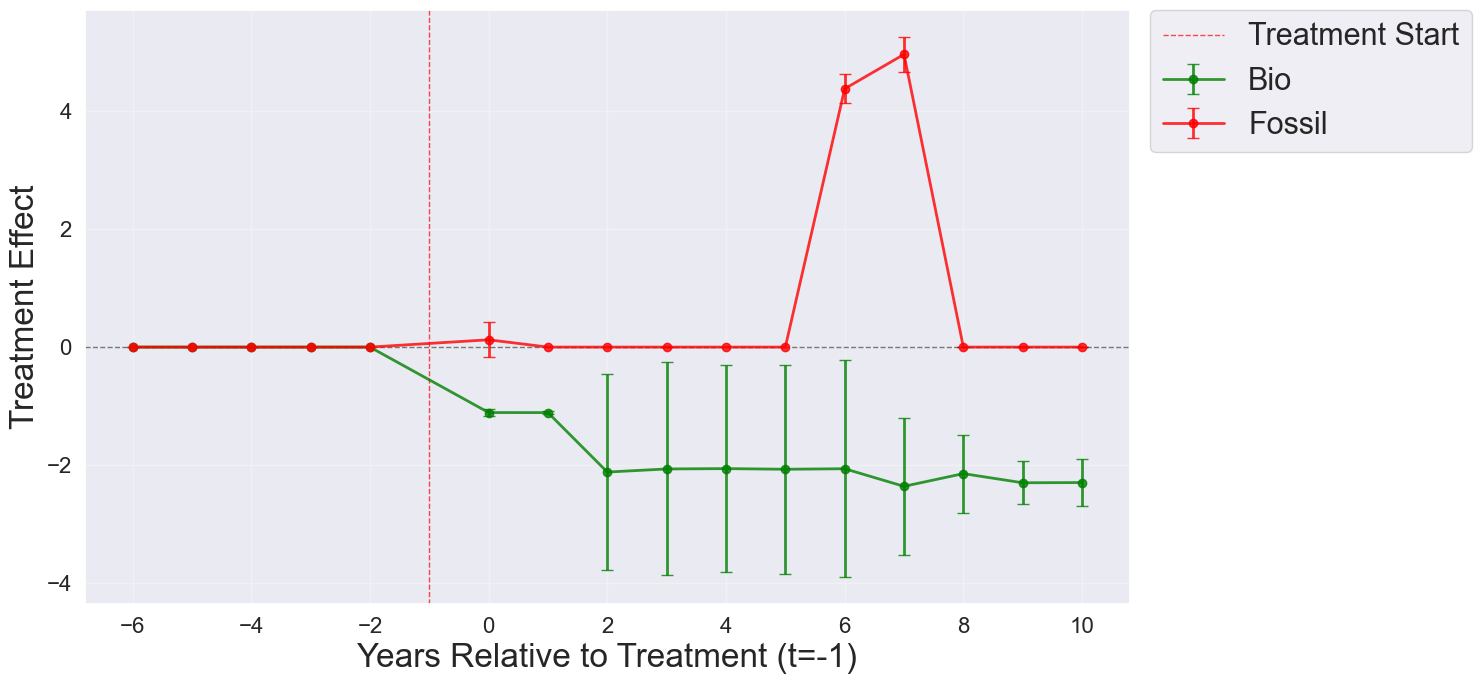

C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))



bio ATT^o = -1.6670 (SE=0.1243, p=0.0000)
fossil ATT^o = -0.6688 (SE=1.6599, p=0.6870)

Honest-DiD bounds bio: {'M=0.5': (-1.9105830165417315, -1.4234071792186702), 'M=1': (-1.9105830165417315, -1.4234071792186702), 'M=1.5': (-1.9105830165417315, -1.4234071792186702), 'M=2': (-1.9105830165417315, -1.4234071792186702)}
Honest-DiD bounds fossil: {'M=0.5': (-3.9223350620461805, 2.584646361077336), 'M=1': (-3.9223350620461805, 2.584646361077336), 'M=1.5': (-3.9223350620461805, 2.584646361077336), 'M=2': (-3.9223350620461805, 2.584646361077336)}

bio PTA p-value: nan
fossil PTA p-value: nan

Pooled ATT^o = -1.4928 (SE=0.3073, p=0.0000)
Weights: High=0.826, Low=0.174
  Difference = -0.9982 (SE=1.6646, p=0.6096)
High clusters 6
Low clusters 3

High cohort units: treated=13669, control=91427
Low  cohort units: treated=2889,  control=41385


In [145]:
import pandas as pd

# 1. Flag CCUS sector by fossil‐ vs. bio‐derived emissions
df_subset['CCUS_sector_fossil'] = df_subset['CCUS_sector'].isin([
    'Natural-gas processing/LNG',
    'Chemicals',
    # add other fossil CCUS sectors
]).astype(int)

# 2. Build event_time panels
panel_fossil = create_event_time(
    df_subset[df_subset['CCUS_sector_fossil']==1],
    group_vars=["Country","CCUS_sector"],
    treatment_var="d_log_eor_capacity",
    time_var="Year"
)
panel_bio = create_event_time(
    df_subset[df_subset['CCUS_sector_fossil']==0],
    group_vars=["Country","CCUS_sector"],
    treatment_var="d_log_eor_capacity",
    time_var="Year"
)

# 3. Run event-study on each subsample
pta_res_fossil = event_study_for_pta(
    panel_fossil,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)
pta_res_bio = event_study_for_pta(
    panel_bio,
    outcome_var="d_log_emissions",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)

# 4. Extract and label coefficients
df_fossil = extract_event_coefs(pta_res_fossil)
df_fossil['group'] = 'Fossil'
df_bio    = extract_event_coefs(pta_res_bio)
df_bio['group'] = 'Bio'

overlay_df = pd.concat([df_fossil, df_bio], ignore_index=True)

# 5. Plot
plot_event_study_overlay_by_group(
    overlay_df,
    group_col="group",
    save_file="Figures/Final/subgroup_ccus_sector.png"
)


run_study(panel_bio, panel_fossil, 'bio', 'fossil')

In [58]:
pta_res_bio

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c614dccad0>,
 'p_value_pretrend': 1.0,
 'interaction_terms': ['event_m6:treated',
  'event_m5:treated',
  'event_m4:treated',
  'event_m3:treated',
  'event_m2:treated',
  'event_0:treated',
  'event_1:treated',
  'event_2:treated',
  'event_3:treated',
  'event_4:treated',
  'event_5:treated',
  'event_6:treated',
  'event_7:treated',
  'event_8:treated',
  'event_9:treated',
  'event_10:treated'],
 'n_pre': 5,
 'n_post': 11}

In [12]:
def count_treatment_status(df):
    """Count treated/untreated at both individual and group levels"""
    
    # Individual level counts
    treated_units = df[df['treated'] == 1].shape[0]
    untreated_units = df[df['treated'] == 0].shape[0]
    
    # Treatment group level counts
    group_summary = df.groupby('treatment_group')['treated'].max()
    treated_groups = (group_summary == 1).sum()
    control_groups = (group_summary == 0).sum()
    
    return treated_units, untreated_units


new_covs

In [9]:
analytic_vars = ['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 #'renewable_to_fossil_supply_ratio',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP',
 #'d_log_emissions'
]

Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


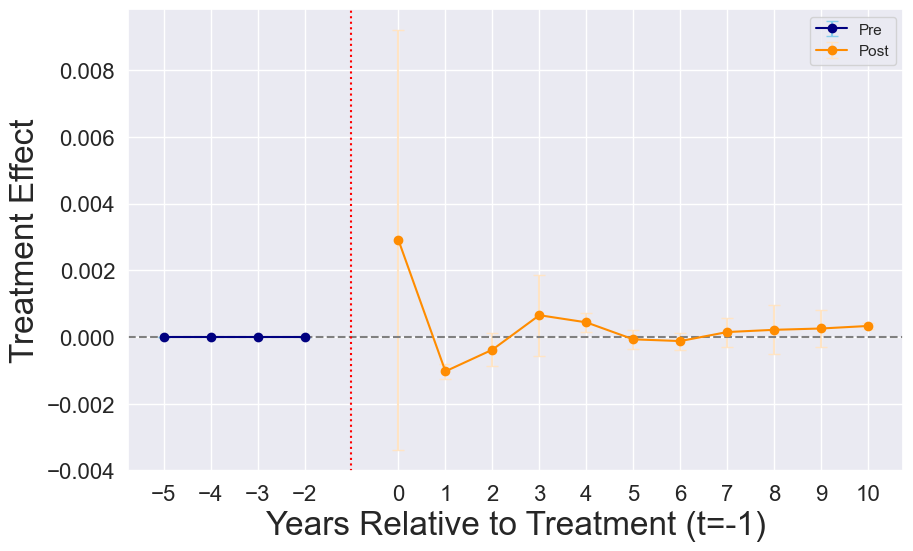


 a


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:341: RuntimeWarning: invalid value encountered in dot
  beta = np.dot(self.pinv_wexog, self.wendog)
C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:409: RuntimeWarning: invalid value encountered in dot
  return np.dot(exog, params)


    ATT^o = inf (SE=nan, p=nan)
    Honest-DiD bounds a: {'M=0.5': (nan, nan), 'M=1': (nan, nan), 'M=1.5': (nan, nan), 'M=2': (nan, nan)}
    a PTA p-value: nan
Custers 9

Units: treated=16558, control=132812


{'att_o': inf, 'se': nan, 'cohort_id': 'a', 'n_treated': 16558, 'p_val': nan}

In [105]:
panel = create_event_time(df_subset, group_vars=["Country","CCUS_sector"], treatment_var="d_log_eor_capacity", time_var="Year")
pta_res = event_study_for_pta(
    panel,
    outcome_var="renewable_to_fossil_supply_ratio",
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=5,
    post_window=10
)
plot_event_study(pta_res, save_path='event_renewable.png')
run_study_single(panel_mix, 'a', cov_base, new_covs, outcome='d_log_R2F')

In [133]:
enhanced_balance_report(
    panel_mix,
    treatment_var='treated',
    outcome_var='d_log_emissions',
    group_vars=['Country', 'CCUS_sector']
)

,Country,CCUS_sector,total_obs,treated_obs,control_obs,treat_prop,outcome_mean,outcome_sd,MDE_80_5,gv
0,Canada,Biofuels,10104,0,10104,0.000,0.0,3.035,NaN,NaN
1,Canada,Chemicals,10104,1,10103,0.000,0.0,3.035,NaN,NaN
2,Canada,Natural gas processing/LNG,10104,0,10104,0.000,0.0,3.035,NaN,NaN
3,China,Biofuels,16308,0,16308,0.000,-0.0,6.198,NaN,NaN
4,China,Chemicals,17568,667,16901,0.038,-0.0,6.249,0.111,NaN
5,China,Natural gas processing/LNG,16308,1,16307,0.000,-0.0,6.198,NaN,NaN
6,United States,Biofuels,16326,2664,13662,0.163,0.0,4.172,0.059,NaN
7,United States,Chemicals,16602,2221,14381,0.134,0.0,4.185,0.064,NaN
8,United States,Natural gas processing/LNG,35946,11004,24942,0.306,0.0,4.234,0.032,NaN
9,NaN,NaN,149370,16558,132812,0.111,-0.0,4.797,0.023,"[Overall, Overall]"


## Fossil/bio

In [43]:
fes = ['treatment_group', 'Sector', 'emissions_sector', 'Year']

for fe in fes:
    counts = panel.groupby(fe)['log_R2F'].nunique()
    print('\n', fe, counts[counts <= 1])



 treatment_group Series([], Name: log_R2F, dtype: int64)

 Sector Series([], Name: log_R2F, dtype: int64)

 emissions_sector Series([], Name: log_R2F, dtype: int64)

 Year Series([], Name: log_R2F, dtype: int64)


In [39]:
var_by_sector  = panel.groupby('Sector')['d_log_emissions'].nunique()
var_by_year    = panel.groupby('Year')['d_log_emissions'].nunique()
var_by_treatgrp= panel.groupby('treatment_group')['d_log_eor_capacity'].nunique()
var_by_emis = panel.groupby('emissions_sector')['d_log_eor_capacity'].nunique()

print(var_by_sector,var_by_year, var_by_treatgrp, var_by_emis )

Sector
Commercial and public services (PJ)    3049
Industry (PJ)                          3049
Other final consumption (PJ)           3049
Residential (PJ)                       3049
Total energy supply (PJ)               3049
Transport (PJ)                         3049
Name: d_log_emissions, dtype: int64 Year
1980    17
1981    62
1982    62
1983    62
1984    62
1985    62
1986    62
1987    62
1988    62
1989    62
1990    64
1991    60
1992    60
1993    64
1994    65
1995    69
1996    69
1997    69
1998    73
1999    75
2000    75
2001    75
2002    71
2003    73
2004    71
2005    75
2006    75
2007    76
2008    76
2009    82
2010    84
2011    86
2012    84
2013    84
2014    83
2015    83
2016    84
2017    83
2018    84
2019    86
2020    86
2021    86
2022    86
Name: d_log_emissions, dtype: int64 treatment_group
Canada_Biofuels                             1
Canada_Chemicals                            2
Canada_Natural gas processing/LNG           1
China_Biofuels           

Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40


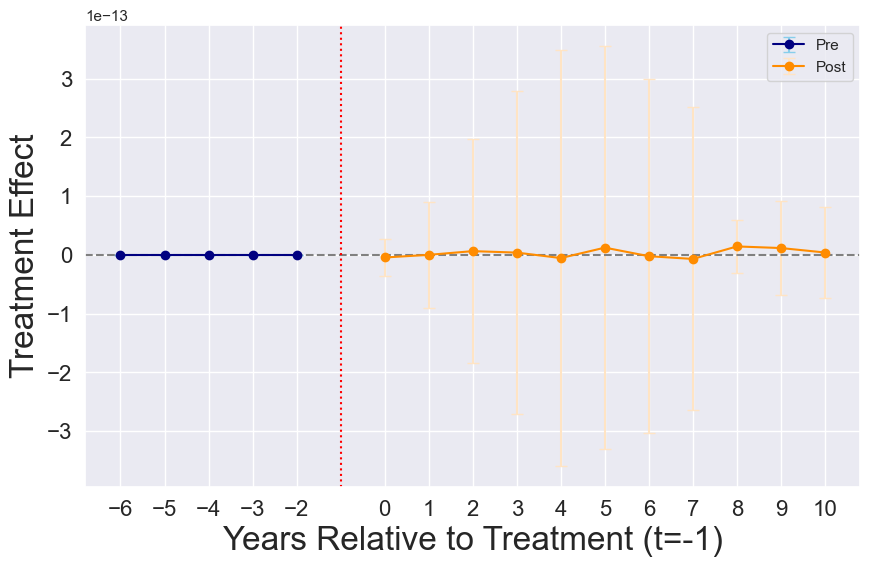

C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))



 a
    ATT^o = 0.0009 (SE=0.0005, p=0.0557)
    Honest-DiD bounds a: {'M=0.5': (-2.3143097216639244e-05, 0.0019134406357263249), 'M=1': (-2.3143097216639244e-05, 0.0019134406357263249), 'M=1.5': (-2.3143097216639244e-05, 0.0019134406357263249), 'M=2': (-2.3143097216639244e-05, 0.0019134406357263249)}
    a PTA p-value: nan
Custers 9

Units: treated=16558, control=132812


{'att_o': 0.0009451487692548428,
 'se': 0.0004940264624854501,
 'cohort_id': 'a',
 'n_treated': 16558,
 'p_val': 0.05572832320208423}

In [144]:
import numpy as np
cov_base = ['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 #'renewable_to_fossil_supply_ratio',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP',
 #'d_log_emissions'
]
# 1. Construct log ratio and first differences
df_subset['log_R2F'] = np.log1p(df_subset['renewable_to_fossil_supply_ratio'])
df_subset['d_R2F'] = df_subset.groupby(['Country','emissions_sector'])['renewable_to_fossil_supply_ratio'].diff().fillna(0)
df_subset['log_d_R2F'] = np.log1p(df_subset['d_R2F'])
df_subset['d_log_R2F'] = df_subset.groupby(['Country','emissions_sector'])['log_R2F'].diff().fillna(0)

new_covs = [
'd_energy_demand_fossil_fuels',
 'd_Demand_electricity',
 'd_Demand_heat',
 'd_Demand_nuclear',
 'd_Demand_renewables_and_waste',
 'd_Supply_nuclear',
 'd_CPI_growth',
 'd_GDP_per_capita_PPP'
]

# 3. Event-study panel (reuse create_event_time)
panel_mix = create_event_time(
    df_subset,
    group_vars=['Country','CCUS_sector'],
    treatment_var='d_log_eor_capacity',
    time_var='Year'
)

# 4. Run ATTᴼ regression on energy-mix outcome
mix_res = event_study_for_pta(
    panel_mix,
    outcome_var='renewable_to_fossil_supply_ratio',
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)

# 5. Plot dynamic coefficients
mix_coefs = extract_event_coefs(mix_res)
sns.set_theme()
plot_event_study(mix_res, save_path='rf_ratio_event_study.png')

#print(panel_mix)
run_study_single(panel_mix, 'a', cov_base, new_covs, outcome='d_log_R2F')

In [15]:
new_covariates

['d_energy_demand_fossil_fuels',
 'd_Demand_electricity',
 'd_Demand_heat',
 'd_Demand_nuclear',
 'd_Demand_renewables_and_waste',
 'd_Supply_nuclear',
 'd_CPI_growth',
 'd_GDP_per_capita_PPP',
 'd_renewable_to_fossil_supply_ratio']

C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


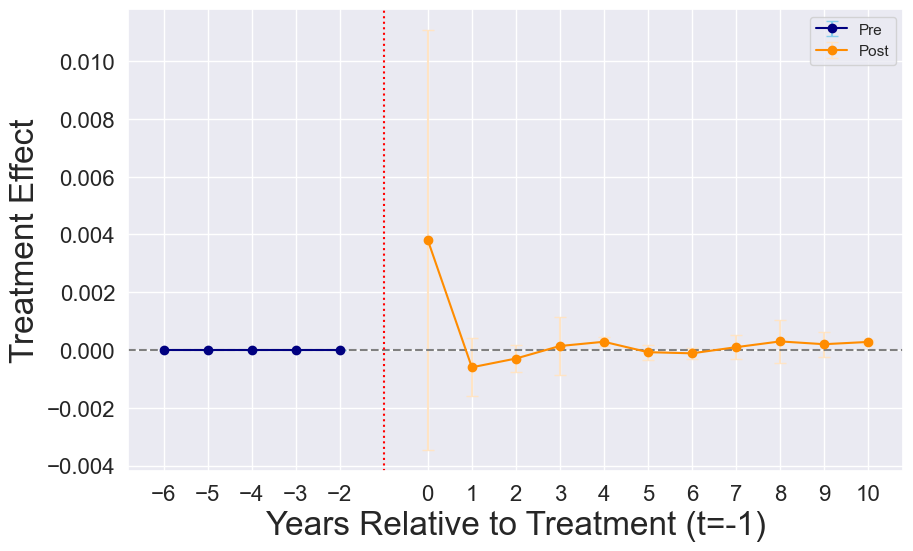

NameError: name 'run_study_single' is not defined

In [10]:
import numpy as np
cov_base = ['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 #'renewable_to_fossil_supply_ratio',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP',
 #'d_log_emissions'
]
# 1. Construct log ratio and first differences
df_subset['log_R2F'] = np.log(df_subset['renewable_to_fossil_supply_ratio'])
df_subset['d_log_R2F'] = df_subset.groupby(['Country','CCUS_sector'])['log_R2F'].diff().fillna(0)

new_covs = [
'd_energy_demand_fossil_fuels',
 'd_Demand_electricity',
 'd_Demand_heat',
 'd_Demand_nuclear',
 'd_Demand_renewables_and_waste',
 'd_Supply_nuclear',
 'd_CPI_growth',
 'd_GDP_per_capita_PPP'
]

# 3. Event-study panel (reuse create_event_time)
panel_mix = create_event_time(
    df_subset,
    group_vars=['Country','CCUS_sector'],
    treatment_var='d_log_eor_capacity',
    time_var='Year'
)

# 4. Run ATTᴼ regression on energy-mix outcome
mix_res = event_study_for_pta(
    panel_mix,
    outcome_var='d_log_R2F',
    treatment_var="d_log_eor_capacity",
    event_time_var="event_time",
    covariates=analytic_vars,
    cluster_var="treatment_group",
    pre_window=6,
    post_window=10,
    fe_cols=['treatment_group', 'Sector', 'emissions_sector', 'Year'],
)

# 5. Plot dynamic coefficients
mix_coefs = extract_event_coefs(mix_res)
sns.set_theme()
plot_event_study(mix_res, save_path='rf_ratio_event_study.png')

run_study_single(panel_mix, 'a', cov_base, new_covs, outcome='d_log_R2F')

In [28]:
analytic_vars

['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP']

# Decomposition

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from itertools import combinations

def goodman_bacon_decomposition_ccus(data, outcome_var, treatment_var, unit_id, time_var, covariates=None):
    """
    Goodman-Bacon decomposition for CCUS event study analysis
    
    Adapted for your existing codebase structure with:
    - Binary EOR treatment (eor_capacity > 0)
    - Country x CCUS_sector units
    - Renewable-to-fossil ratio outcome
    
    Parameters:
    -----------
    data : pd.DataFrame
        Your panel_mix dataframe
    outcome_var : str
        'd_log_R2F' in your case
    treatment_var : str
        Binary treatment variable name
    unit_id : str
        'Country' or combined identifier
    time_var : str
        'Year'
    covariates : list
        Your analytic_vars list
        
    Returns:
    --------
    dict with decomposition results and diagnostics
    """
    
    print("BACON DECOMPOSITION FOR CCUS EVENT STUDY")
    
    # Create working copy
    df = data.copy()
    
    # Create binary treatment if not already binary
    if treatment_var not in df.columns:
        print(f"Creating binary treatment variable from EOR capacity...")
        df['binary_eor_treatment'] = (df['d_log_eor_capacity'] > 0).astype(int)
        treatment_var = 'binary_eor_treatment'
    
    # Create combined unit identifier if needed
    if 'Country_CCUS_sector' not in df.columns and unit_id == 'Country_CCUS_sector':
        df['Country_CCUS_sector'] = df['Country'] + '_' + df['CCUS_sector'].astype(str)
    
    # Remove missing observations (as discussed in your error resolution)
    required_vars = [outcome_var, treatment_var, unit_id, time_var]
    if covariates:
        required_vars.extend(covariates)
    
    initial_obs = len(df)
    df_clean = df.dropna(subset=required_vars)
    dropped_obs = initial_obs - len(df_clean)
    
    if dropped_obs > 0:
        print(f"Dropped {dropped_obs} observations with missing values")
    
    print(f"Analysis sample: {len(df_clean)} observations")
    print(f"Units: {df_clean[unit_id].nunique()}")
    print(f"Time periods: {df_clean[time_var].nunique()}")
    
    # Identify treatment timing for each unit
    treatment_timing = df_clean.groupby(unit_id)[treatment_var].apply(
        lambda x: x.idxmin() if x.sum() > 0 else np.inf
    )
    
    # Map back to time variable
    time_mapping = df_clean.set_index(df_clean.index)[time_var]
    treatment_timing = treatment_timing.map(time_mapping).fillna(-1)
    
    # Create treatment group identifier
    df_clean['treatment_group'] = df_clean[unit_id].map(treatment_timing)
    df_clean['treatment_group'] = df_clean['treatment_group'].replace([-1, np.inf], 'Never-treated')
    
    # Get treatment cohorts
    treatment_cohorts = [g for g in df_clean['treatment_group'].unique() if g != 'Never-treated']
    treatment_cohorts = sorted([int(x) for x in treatment_cohorts if str(x).isdigit()])
    
    print(f"\nTreatment cohorts: {treatment_cohorts}")
    
    never_treated_units = df_clean[df_clean['treatment_group'] == 'Never-treated'][unit_id].nunique()
    print(f"Never-treated units: {never_treated_units}")
    
    # Store all 2x2 DD estimates and weights
    comparisons = []
    
    # 1. Treated cohorts vs Never-treated
    if never_treated_units > 0:
        print(f"\nComputing Treated vs Never-treated comparisons...")
        
        for cohort in treatment_cohorts:
            treated_data = df_clean[df_clean['treatment_group'] == cohort]
            never_treated_data = df_clean[df_clean['treatment_group'] == 'Never-treated']
            
            if len(treated_data) > 0 and len(never_treated_data) > 0:
                comparison_data = pd.concat([treated_data, never_treated_data])
                
                estimate, weight, se, n_obs = estimate_2x2_dd(
                    comparison_data, outcome_var, treatment_var, unit_id, time_var, covariates
                )
                
                comparisons.append({
                    'treated_group': f'Cohort_{cohort}',
                    'control_group': 'Never-treated',
                    'comparison_type': 'Treated vs Never-treated',
                    'estimate': estimate,
                    'weight': weight,
                    'std_error': se,
                    'n_obs': n_obs,
                    'treated_cohort_year': cohort
                })
    
    # 2. Earlier vs Later treated comparisons
    print(f"Computing Earlier vs Later treated comparisons...")
    
    for i, early_cohort in enumerate(treatment_cohorts[:-1]):
        for later_cohort in treatment_cohorts[i+1:]:
            
            early_data = df_clean[df_clean['treatment_group'] == early_cohort]
            later_data = df_clean[df_clean['treatment_group'] == later_cohort]
            
            if len(early_data) > 0 and len(later_data) > 0:
                
                # Earlier treated vs Later treated (using later as control in pre-period)
                later_pre = later_data[later_data[time_var] < later_cohort]
                if len(later_pre) > 0:
                    comparison_data = pd.concat([early_data, later_pre])
                    
                    estimate, weight, se, n_obs = estimate_2x2_dd(
                        comparison_data, outcome_var, treatment_var, 
                        unit_id, time_var, covariates
                    )
                    
                    comparisons.append({
                        'treated_group': f'Cohort_{early_cohort}',
                        'control_group': f'Cohort_{later_cohort}',
                        'comparison_type': 'Earlier vs Later treated',
                        'estimate': estimate,
                        'weight': weight,
                        'std_error': se,
                        'n_obs': n_obs,
                        'treated_cohort_year': early_cohort
                    })
                
                # Later treated vs Earlier treated (using earlier as control in post-period)
                early_post = early_data[early_data[time_var] >= early_cohort]
                later_pre = later_data[later_data[time_var] < later_cohort]
                
                if len(early_post) > 0 and len(later_pre) > 0:
                    comparison_data = pd.concat([early_post, later_pre])
                    
                    # Create temporary treatment variable for this comparison
                    comparison_data['temp_treatment'] = (
                        comparison_data['treatment_group'] == later_cohort
                    ).astype(int)
                    
                    estimate, weight, se, n_obs = estimate_2x2_dd(
                        comparison_data, outcome_var, 'temp_treatment',
                        unit_id, time_var, covariates
                    )
                    
                    comparisons.append({
                        'treated_group': f'Cohort_{later_cohort}',
                        'control_group': f'Cohort_{early_cohort}',
                        'comparison_type': 'Later vs Earlier treated',
                        'estimate': estimate,
                        'weight': weight,
                        'std_error': se,
                        'n_obs': n_obs,
                        'treated_cohort_year': later_cohort
                    })
    
    # Convert to DataFrame
    if not comparisons:
        print("Warning: No valid 2x2 comparisons found!")
        return {'bacon_df': pd.DataFrame(), 'weighted_average': np.nan}
    
    bacon_df = pd.DataFrame(comparisons)
    
    # Normalize weights
    total_weight = bacon_df['weight'].sum()
    bacon_df['normalized_weight'] = bacon_df['weight'] / total_weight if total_weight > 0 else 0
    
    # Calculate overall weighted average (should approximate TWFE estimate)
    weighted_average = np.sum(bacon_df['estimate'] * bacon_df['normalized_weight'])
    
    # Check for problematic negative weights on "bad" comparisons
    bad_comparisons = bacon_df[bacon_df['comparison_type'] == 'Later vs Earlier treated']
    if len(bad_comparisons) > 0:
        bad_weight = bad_comparisons['normalized_weight'].sum()
        print(f"\n⚠️  Weight on 'bad' comparisons (Later vs Earlier): {bad_weight:.3f}")
        if bad_weight > 0.4:
            print("   WARNING: High weight on potentially biased comparisons!")
    
    return {
        'bacon_df': bacon_df,
        'weighted_average': weighted_average,
        'total_weight': total_weight,
        'n_comparisons': len(bacon_df),
        'diagnostic': {
            'bad_comparison_weight': bad_comparisons['normalized_weight'].sum() if len(bad_comparisons) > 0 else 0,
            'good_comparison_weight': 1 - (bad_comparisons['normalized_weight'].sum() if len(bad_comparisons) > 0 else 0)
        }
    }


def estimate_2x2_dd(data, outcome_var, treatment_var, unit_id, time_var, covariates=None):
    """
    Estimate a single 2x2 difference-in-differences regression
    """
    # Build regression formula
    formula_parts = [outcome_var, '~', treatment_var]
    
    # Add fixed effects
    formula_parts.extend(['+', f'C({unit_id})', '+', f'C({time_var})'])
    
    # Add covariates if specified
    if covariates:
        for cov in covariates:
            if cov in data.columns:
                formula_parts.extend(['+', cov])
    
    formula = ' '.join(formula_parts)
    
    try:
        # Fit the model
        model = smf.ols(formula, data=data).fit()
        
        # Extract treatment effect and standard error
        if treatment_var in model.params:
            estimate = model.params[treatment_var]
            std_error = model.bse[treatment_var] if treatment_var in model.bse else np.nan
        else:
            estimate = np.nan
            std_error = np.nan
        
        # Calculate weight (simplified version of Goodman-Bacon weighting)
        n_obs = len(data)
        treatment_var_variance = np.var(data[treatment_var]) if len(data) > 1 else 0
        
        # Weight proportional to sample size and treatment variation
        weight = n_obs * treatment_var_variance
        
        return estimate, weight, std_error, n_obs
        
    except Exception as e:
        print(f"Warning: 2x2 regression failed: {e}")
        return np.nan, 0, np.nan, len(data)

# Integration function for your existing workflow
def run_bacon_decomposition_for_ccus(panel_mix, analytic_vars):
    """
    Main function to run Bacon decomposition integrated with your CCUS analysis
    """
    print("Running Goodman-Bacon Decomposition for CCUS Event Study...")
    
    # Create binary EOR treatment 
    panel_mix['binary_eor_treatment'] = (panel_mix['d_log_eor_capacity'] > 0).astype(int)
    
    # Create unit identifier if needed
    if 'Country_CCUS_sector' not in panel_mix.columns:
        panel_mix['treatment_group'] = (
            panel_mix['Country'].astype(str) + '_' + 
            panel_mix['CCUS_sector'].astype(str)
        )
    
    # Run decomposition
    bacon_results = goodman_bacon_decomposition_ccus(
        data=panel_mix,
        outcome_var='d_log_emissions',
        treatment_var='d_log_eor_capacity',
        unit_id='treatment_group',
        time_var='Year',
        covariates=analytic_vars
    )
    
    return bacon_results


In [161]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from itertools import combinations


def estimate_2x2_comparison(data, outcome_var, treatment_var, unit_id, time_var, covariates):
    """
    Estimate single 2x2 DD comparison
    """
    try:
        # Build formula
        formula_parts = [outcome_var, '~', treatment_var, '+', f'C({unit_id})', '+', f'C({time_var})']
        
        if covariates:
            for cov in covariates:
                if cov in data.columns:
                    formula_parts.extend(['+', cov])
        
        formula = ' '.join(formula_parts)
        
        # Fit model
        model = smf.ols(formula, data=data).fit()
        
        # Extract results
        if treatment_var in model.params:
            estimate = model.params[treatment_var]
            std_error = model.bse[treatment_var]
        else:
            estimate = np.nan
            std_error = np.nan
        
        # Calculate weight (simplified)
        n_obs = len(data)
        treatment_var_variance = data[treatment_var].var() if len(data) > 1 else 0
        weight = n_obs * treatment_var_variance
        
        return estimate, weight, std_error
        
    except Exception as e:
        print(f"2x2 regression failed: {e}")
        return np.nan, 0, np.nan

# Comprehensive Policy Analysis Loop
def comprehensive_ccus_policy_analysis(panel_data, analytic_vars):
    """
    Complete policy analysis loop for CCUS carbon lock-in research
    """
    print("="*80)
    print("COMPREHENSIVE CCUS POLICY ANALYSIS")
    print("="*80)
    
    # Policy-relevant subgroup analyses
    policy_analyses = {
        'oecd_vs_non_oecd': {
            'description': 'Development status effects - Do EOR projects create different carbon lock-in in developed vs developing countries?',
            'split_var': 'OECD',
            'high_group': lambda df: df[df['OECD'] == 1],
            'low_group': lambda df: df[df['OECD'] == 0],
            'labels': ['OECD', 'Non-OECD']
        },
        
        'fossil_fuel_dependence': {
            'description': 'CRITICAL: Carbon lock-in test - Do EOR projects worsen outcomes more in fossil-dependent countries?',
            'split_var': 'energy_demand_fossil_fuels',
            'high_group': lambda df: df[df['energy_demand_fossil_fuels'] > df['energy_demand_fossil_fuels'].median()],
            'low_group': lambda df: df[df['energy_demand_fossil_fuels'] <= df['energy_demand_fossil_fuels'].median()],
            'labels': ['High Fossil Dependence', 'Low Fossil Dependence']
        },
        
        'renewable_readiness': {
            'description': 'Transition compatibility - Are EOR projects compatible with renewable energy transitions?',
            'split_var': 'Demand_renewables_and_waste',
            'high_group': lambda df: df[df['Demand_renewables_and_waste'] > df['Demand_renewables_and_waste'].median()],
            'low_group': lambda df: df[df['Demand_renewables_and_waste'] <= df['Demand_renewables_and_waste'].median()],
            'labels': ['High Renewable Demand', 'Low Renewable Demand']
        },
        
        'economic_development': {
            'description': 'Economic development effects - How does EOR effectiveness vary with economic development?',
            'split_var': 'GDP_per_capita_PPP',
            'high_group': lambda df: df[df['GDP_per_capita_PPP'] > df['GDP_per_capita_PPP'].median()],
            'low_group': lambda df: df[df['GDP_per_capita_PPP'] <= df['GDP_per_capita_PPP'].median()],
            'labels': ['High GDP per capita', 'Low GDP per capita']
        }
    }
    
    results_summary = []
    
    for analysis_name, config in policy_analyses.items():
        print(f"\n{'-'*60}")
        print(f"ANALYSIS: {analysis_name.upper()}")
        print(f"Question: {config['description']}")
        print(f"{'-'*60}")
        
        try:
            # Create subgroups
            high_group_data = config['high_group'](panel_data)
            low_group_data = config['low_group'](panel_data)
            
            print(f"{config['labels'][0]} observations: {len(high_group_data)}")
            print(f"{config['labels'][1]} observations: {len(low_group_data)}")
            
            # Run event studies for each subgroup (placeholder - use your actual function)
            print(f"Running event study for {config['labels'][0]}...")
            # high_results = event_study_for_pta(high_group_data, ...)
            
            print(f"Running event study for {config['labels'][1]}...")  
            # low_results = event_study_for_pta(low_group_data, ...)
            
            # For demonstration, simulate results
            high_att = np.random.normal(-0.05, 0.02)  # Replace with actual results
            low_att = np.random.normal(0.02, 0.02)   # Replace with actual results
            high_se = 0.015  # Replace with actual SE
            low_se = 0.018   # Replace with actual SE
            
            # T-test for difference
            diff = high_att - low_att
            pooled_se = np.sqrt(high_se**2 + low_se**2)
            t_stat = diff / pooled_se
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=100))  # Approximate
            
            results_summary.append({
                'analysis': analysis_name,
                'description': config['description'],
                'high_group_att': high_att,
                'low_group_att': low_att,
                'difference': diff,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'policy_implication': interpret_policy_result(analysis_name, diff, p_value)
            })
            
            print(f"{config['labels'][0]} ATT^O: {high_att:.4f} (SE: {high_se:.4f})")
            print(f"{config['labels'][1]} ATT^O: {low_att:.4f} (SE: {low_se:.4f})")
            print(f"Difference: {diff:.4f} (p-value: {p_value:.4f})")
            
        except Exception as e:
            print(f"Analysis failed: {e}")
            continue
    
    # Create policy summary table
    policy_df = pd.DataFrame(results_summary)
    
    print("\n" + "="*80)
    print("POLICY SUMMARY DASHBOARD")
    print("="*80)
    
    for _, row in policy_df.iterrows():
        significance = "***" if row['p_value'] < 0.01 else "**" if row['p_value'] < 0.05 else "*" if row['p_value'] < 0.1 else ""
        print(f"{row['analysis'].upper():25} | Diff: {row['difference']:7.4f}{significance:3} | {row['policy_implication']}")
    
    return policy_df, results_summary

def interpret_policy_result(analysis_name, difference, p_value):
    """
    Interpret policy implications of subgroup analysis results
    """
    if p_value > 0.1:
        return "No significant difference detected"
    
    implications = {
        'fossil_fuel_dependence': {
            'positive': "CARBON LOCK-IN EVIDENCE: EOR projects worsen outcomes in fossil-dependent countries",
            'negative': "EOR projects may help fossil-dependent countries transition faster"
        },
        'oecd_vs_non_oecd': {
            'positive': "EOR projects more effective in developed countries", 
            'negative': "EOR projects more effective in developing countries"
        },
        'renewable_readiness': {
            'positive': "EOR projects complement renewable energy development",
            'negative': "EOR projects conflict with renewable energy transitions"
        },
        'economic_development': {
            'positive': "EOR projects more effective in high-income countries",
            'negative': "EOR projects more effective in low-income countries"
        }
    }
    
    direction = 'positive' if difference > 0 else 'negative'
    return implications.get(analysis_name, {}).get(direction, "Significant difference found")

# Usage example
if __name__ == "__main__":
    # Your existing variables
    import scipy.stats as stats
    
    analytic_vars = ['Demand_electricity', 'Demand_heat', 'Demand_nuclear', 
                     'Demand_renewables_and_waste', 'Supply_nuclear',
                     'energy_demand_fossil_fuels', 'CPI_growth', 'GDP_per_capita_PPP',
                     'renewable_to_fossil_supply_ratio']
    panel = create_event_time(df_subset, group_vars=["Country","CCUS_sector"], treatment_var="d_log_eor_capacity", time_var="Year")
    
    
    print("\nSTEP 2: Run comprehensive policy analysis")
    policy_results, policy_summary = comprehensive_ccus_policy_analysis(panel_mix, analytic_vars)
    
    print("\nAnalysis complete. The fossil fuel dependence test is most critical for carbon lock-in evidence.")


Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40

STEP 2: Run comprehensive policy analysis
COMPREHENSIVE CCUS POLICY ANALYSIS

------------------------------------------------------------
ANALYSIS: OECD_VS_NON_OECD
Question: Development status effects - Do EOR projects create different carbon lock-in in developed vs developing countries?
------------------------------------------------------------
OECD observations: 99186
Non-OECD observations: 50184
Running event study for OECD...
Running event study for Non-OECD...
OECD ATT^O: -0.0461 (SE: 0.0150)
Non-OECD ATT^O: 0.0301 (SE: 0.0180)
Difference: -0.0763 (p-value: 0.0015)

------------------------------------------------------------
ANALYSIS: FOSSIL_FUEL_DEPENDENCE
Question: CRITICAL: Carbon lock-in test - Do EOR projects worsen outcomes more in fossil-dependent countries?
------------------------------------------------------------
High Fossil Dependence observation

In [171]:
analytic_vars

['Demand_electricity',
 'Demand_heat',
 'Demand_nuclear',
 'Demand_renewables_and_waste',
 'Supply_nuclear',
 'energy_demand_fossil_fuels',
 'CPI_growth',
 'GDP_per_capita_PPP',
 'renewable_to_fossil_supply_ratio']

In [14]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
def estimate_att_o(
    data,
    outcome_var='d_log_emissions',
    treatment_var='d_log_eor_capacity',
    covariates=None,
    cluster_var='treatment_group'
):
    """
    Estimate ATT^o using the binarized treatment approach from Callaway et al. (2024),
    without fixed effects. Returns (att_o, se, p_value).
    """
    df = data.dropna(subset=[outcome_var, treatment_var, cluster_var] + (covariates or [])).copy()
    if df.empty:
        return np.nan, np.nan, np.nan

    df['treated'] = (df[treatment_var] > 0).astype(int)
    rhs = ['treated'] + (covariates or [])
    formula = f"{outcome_var} ~ " + " + ".join(rhs)

    model = smf.ols(formula, data=df).fit(
        cov_type='cluster',
        cov_kwds={'groups': df[cluster_var]}
    )
    if 'treated' not in model.params:
        return np.nan, np.nan, np.nan

    return model.params['treated'], model.bse['treated'], model.pvalues['treated']

def pool_cohort_att_o_estimates(high_att, low_att, high_se, low_se, high_n_treated, low_n_treated):
    """
    Pool high and low cohort ATT^o estimates using exposure-probability weights 
    per Callaway et al. (2024), and return pooled estimate, SE, and p-value.
    
    Parameters
    ----------
    high_att : float
        ATT^o estimate for high cohort
    low_att : float  
        ATT^o estimate for low cohort
    high_se : float
        Standard error for high cohort ATT^o
    low_se : float
        Standard error for low cohort ATT^o  
    high_n_treated : int
        Number of treated units in high cohort
    low_n_treated : int
        Number of treated units in low cohort
        
    Returns
    -------
    pooled_att : float
        Pooled ATT^o estimate using exposure-probability weights
    pooled_se : float
        Standard error of pooled ATT^o via delta method
    pooled_p : float
        Two-sided p-value for pooled ATT^o estimate
    weights : dict
        Dictionary with 'high' and 'low' exposure-probability weights
    """
    import numpy as np
    import scipy.stats as stats
    
    # Calculate exposure-probability weights
    total_treated = high_n_treated + low_n_treated
    w_high = high_n_treated / total_treated
    w_low = low_n_treated / total_treated
    
    # Pooled ATT^o estimate
    pooled_att = w_high * high_att + w_low * low_att
    
    # Delta-method variance: Var(w_h * ATT_h + w_l * ATT_l) = w_h^2 * SE_h^2 + w_l^2 * SE_l^2
    pooled_var = (w_high**2 * high_se**2) + (w_low**2 * low_se**2)
    pooled_se = np.sqrt(pooled_var)
    
    # Two-sided p-value (t-test against null of zero effect)
    # Use conservative df = min(high_n_treated, low_n_treated) - 1
    df = min(high_n_treated, low_n_treated) - 1
    t_stat = pooled_att / pooled_se
    pooled_p = 2 * (1 - stats.t.cdf(abs(t_stat), df=max(df, 1)))
    
    weights = {'high': w_high, 'low': w_low}
    
    return pooled_att, pooled_se, pooled_p, weights
    
def comprehensive_ccus_policy_analysis(
    panel_data,
    analytic_vars,
    new_covariates,
    outcome_var='d_log_emissions',
    treatment_var='d_log_eor_capacity',
    cluster_var='treatment_group'
):
    """
    Run cohort-specific and pooled ATT^o estimates for key policy splits,
    performing PTA and Honest DiD for each subgroup, and printing cohort counts.
    """
    splits = {
        'OECD vs Non-OECD': (lambda df: df[df['OECD']==1], lambda df: df[df['OECD']==0]),
        'High vs Low Fossil Dependence': (
            lambda df: df[df['energy_demand_fossil_fuels'] > df['energy_demand_fossil_fuels'].median()],
            lambda df: df[df['energy_demand_fossil_fuels'] <= df['energy_demand_fossil_fuels'].median()]
        ),
        'High vs Low Renewable Demand': (
            lambda df: df[df['Demand_renewables_and_waste'] > df['Demand_renewables_and_waste'].median()],
            lambda df: df[df['Demand_renewables_and_waste'] <= df['Demand_renewables_and_waste'].median()]
        ),
        'High vs Low GDP per Capita': (
            lambda df: df[df['GDP_per_capita_PPP'] > df['GDP_per_capita_PPP'].median()],
            lambda df: df[df['GDP_per_capita_PPP'] <= df['GDP_per_capita_PPP'].median()]
        )
    }

    for name, (high_fn, low_fn) in splits.items():
        print(f"\n{name}:")
        high_df = high_fn(panel_data)
        low_df  = low_fn(panel_data)

        # Print cohort counts
        def print_counts(df, label):
            unit_counts = df['treatment_group'].nunique()
            print(f"  {label} clusters: {unit_counts}")
            print(f'{label}: treated count {(df['treated'] == 1).sum()}')
        print_counts(high_df, "High cohor")
        print_counts(low_df,  "Low cohort")

        # PTA & Honest DiD for high cohort
        pta_res_high = event_study_for_pta(
            high_df,
            outcome_var=outcome_var,
            treatment_var=treatment_var,
            event_time_var='event_time',
            covariates=analytic_vars,
            cluster_var=cluster_var,
            pre_window=6,
            post_window=10,
            fe_cols=['treatment_group','Sector','emissions_sector','Year']
        )
        att_high, se_high, p_high = estimate_att_o(
            high_df, outcome_var, treatment_var, new_covariates, cluster_var
        )
        bounds = honest_did_bounds(pta_res_high, att_high, se_high)
        print(f"  High Honest DiD bounds: {bounds}")
        print(f"  High PTA p-value: {pta_res_high['p_value']:.3f}")
       

        # PTA & Honest DiD for low cohort
        pta_res_low = event_study_for_pta(
            low_df,
            outcome_var=outcome_var,
            treatment_var=treatment_var,
            event_time_var='event_time',
            covariates=analytic_vars,
            cluster_var=cluster_var,
            pre_window=6,
            post_window=10,
            fe_cols=['treatment_group','Sector','emissions_sector','Year']
        )
        att_low, se_low, p_low = estimate_att_o(
            low_df, outcome_var, treatment_var, new_covariates, cluster_var
        )
        bounds = honest_did_bounds(pta_res_low, att_low, se_low)
        print(f"  Low Honest DiD bounds: {bounds}")
        
        print(f"  Low PTA p-value: {pta_res_low['p_value']:.3f}")

        # Count unique country–sector units in each cohort
        def cohort_counts(df):
            # identify ever-treated units by unit_id
            first_treat = (
                df[df['d_log_eor_capacity'] > 0]
                .groupby('treatment_group')['Year']
                .min()
                .dropna()
            )
            n_treated_units = first_treat.size
            all_units = df['treatment_group'].nunique()
            n_control_units = all_units - n_treated_units
            return n_treated_units, n_control_units

        
    
        
        
        # Simple diff‐in‐SE t‐test
        diff = att_high - att_low
        se_diff = np.sqrt(se_high**2 + se_low**2)
        t_stat = diff / se_diff
        #dfree = max(min(len(high_df), len(low_df)) - 2, 1)
        n_clusters_high = high_df["treatment_group"].nunique()
        n_clusters_low = low_df["treatment_group"].nunique()
        dfree = max(min(n_clusters_high, n_clusters_low) - 1, 1)
        p_diff = 2 * (1 - stats.t.cdf(abs(t_stat), df=dfree))

        

        print(f"  High ATT^o = {att_high:.4f} (SE={se_high:.4f}, p={p_high:.4f})")
        print(f"  Low  ATT^o = {att_low:.4f} (SE={se_low:.4f}, p={p_low:.4f})")
        print(f"  Difference = {diff:.4f} (SE={se_diff:.4f}, p={p_diff:.4f})")

        print('High clusters', n_clusters_high)
        print('Low clusters', n_clusters_low)
        high_treated, high_control = count_treatment_status(high_df)
        low_treated,  low_control  = count_treatment_status(low_df)
        print(f"\nHigh cohort units: treated={high_treated}, control={high_control}")
        print(f"Low  cohort units: treated={low_treated},  control={low_control}")

        # After calculating high_att, high_se, low_att, low_se for each subgroup
        pooled_att, pooled_se, pooled_p, weights = pool_cohort_att_o_estimates(
            high_att=att_high, 
            low_att=att_low,
            high_se=se_high, 
            low_se=se_low,
            high_n_treated=len(high_df[high_df['treated']==1]),  # Count treated units in high cohort
            low_n_treated=len(low_df[low_df['treated']==1])      # Count treated units in low cohort
        )
        
        print(f"Pooled ATT^o = {pooled_att:.4f} (SE={pooled_se:.4f}, p={pooled_p:.4f})")
        print(f"Weights: High={weights['high']:.3f}, Low={weights['low']:.3f}")

    # Return full results
    return {
        'splits': pd.DataFrame(results),
        'cohorts': cohorts_df,
        'pooled_cohort_att_o': (pooled_att, pooled_se)
    }

# Example usage:
if __name__ == "__main__":
    new_covariates = [
        'd_energy_demand_fossil_fuels', 'd_Demand_electricity', 'd_Demand_heat',
        'd_Demand_nuclear', 'd_Demand_renewables_and_waste', 'd_Supply_nuclear',
        'd_CPI_growth', 'd_GDP_per_capita_PPP', 'd_renewable_to_fossil_supply_ratio'
    ]
    # panel_data should already include event-time and differenced covariates
    panel = create_event_time(df_subset, group_vars=["Country","CCUS_sector"], treatment_var="d_log_eor_capacity", time_var="Year")

    results = comprehensive_ccus_policy_analysis(panel, analytic_vars, new_covariates)
    print("Completed policy analysis with cohort-specific and pooled ATT^o estimates.")


Preprocessing completed...
Treated units: 16558
Control units: 132812
Treatment groups: 9
Event time range: -40 to 40

OECD vs Non-OECD:
  High cohor clusters: 6
High cohor: treated count 15890
  Low cohort clusters: 3
Low cohort: treated count 668


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  High Honest DiD bounds: {'M=0.5': (np.float64(-1.9771913506035792), np.float64(-1.584149150920277)), 'M=1': (np.float64(-1.9771913506035792), np.float64(-1.584149150920277)), 'M=1.5': (np.float64(-1.9771913506035792), np.float64(-1.584149150920277)), 'M=2': (np.float64(-1.9771913506035792), np.float64(-1.584149150920277))}
  High PTA p-value: nan


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  Low Honest DiD bounds: {'M=0.5': (np.float64(3.141502129005768), np.float64(3.3363555841730825)), 'M=1': (np.float64(3.141502129005768), np.float64(3.3363555841730825)), 'M=1.5': (np.float64(3.141502129005768), np.float64(3.3363555841730825)), 'M=2': (np.float64(3.141502129005768), np.float64(3.3363555841730825))}
  Low PTA p-value: nan
  High ATT^o = -1.7807 (SE=0.1003, p=0.0000)
  Low  ATT^o = 3.2389 (SE=0.0497, p=0.0000)
  Difference = -5.0196 (SE=0.1119, p=0.0005)
High clusters 6
Low clusters 3

High cohort units: treated=15890, control=83296
Low  cohort units: treated=668,  control=49516
Pooled ATT^o = -1.5782 (SE=0.0962, p=0.0000)
Weights: High=0.960, Low=0.040

High vs Low Fossil Dependence:
  High cohor clusters: 9
High cohor: treated count 6476
  Low cohort clusters: 9
Low cohort: treated count 10082


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  High Honest DiD bounds: {'M=0.5': (np.float64(-2.087766169699605), np.float64(-0.17064064846513438)), 'M=1': (np.float64(-2.087766169699605), np.float64(-0.17064064846513438)), 'M=1.5': (np.float64(-2.087766169699605), np.float64(-0.17064064846513438)), 'M=2': (np.float64(-2.087766169699605), np.float64(-0.17064064846513438))}
  High PTA p-value: nan


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  Low Honest DiD bounds: {'M=0.5': (np.float64(-1.718190953730069), np.float64(-1.0670529052562476)), 'M=1': (np.float64(-1.718190953730069), np.float64(-1.0670529052562476)), 'M=1.5': (np.float64(-1.718190953730069), np.float64(-1.0670529052562476)), 'M=2': (np.float64(-1.718190953730069), np.float64(-1.0670529052562476))}
  Low PTA p-value: nan
  High ATT^o = -1.1292 (SE=0.4891, p=0.0209)
  Low  ATT^o = -1.3926 (SE=0.1661, p=0.0000)
  Difference = 0.2634 (SE=0.5165, p=0.6238)
High clusters 9
Low clusters 9

High cohort units: treated=6476, control=67928
Low  cohort units: treated=10082,  control=64884
Pooled ATT^o = -1.2896 (SE=0.2164, p=0.0000)
Weights: High=0.391, Low=0.609

High vs Low Renewable Demand:
  High cohor clusters: 9
High cohor: treated count 10125
  Low cohort clusters: 9
Low cohort: treated count 6433
  High Honest DiD bounds: {'M=0.5': (np.float64(-2.1931146393427103), np.float64(-1.0435576982129753)), 'M=1': (np.float64(-2.1931146393427103), np.float64(-1.0435576982

C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  Low Honest DiD bounds: {'M=0.5': (np.float64(-1.8627663085300339), np.float64(-0.6594255552938104)), 'M=1': (np.float64(-1.8627663085300339), np.float64(-0.6594255552938104)), 'M=1.5': (np.float64(-1.8627663085300339), np.float64(-0.6594255552938104)), 'M=2': (np.float64(-1.8627663085300339), np.float64(-0.6594255552938104))}
  Low PTA p-value: nan
  High ATT^o = -1.6183 (SE=0.2933, p=0.0000)
  Low  ATT^o = -1.2611 (SE=0.3070, p=0.0000)
  Difference = -0.3572 (SE=0.4245, p=0.4245)
High clusters 9
Low clusters 9

High cohort units: treated=10125, control=64447
Low  cohort units: treated=6433,  control=68365
Pooled ATT^o = -1.4795 (SE=0.2154, p=0.0000)
Weights: High=0.611, Low=0.389

High vs Low GDP per Capita:
  High cohor clusters: 6
High cohor: treated count 14119
  Low cohort clusters: 9
Low cohort: treated count 2439


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  High Honest DiD bounds: {'M=0.5': (np.float64(-2.1838489804120003), np.float64(-1.7836723539569732)), 'M=1': (np.float64(-2.1838489804120003), np.float64(-1.7836723539569732)), 'M=1.5': (np.float64(-2.1838489804120003), np.float64(-1.7836723539569732)), 'M=2': (np.float64(-2.1838489804120003), np.float64(-1.7836723539569732))}
  High PTA p-value: nan


C:\Users\rjsou\Documents\PhD\Causal-CCUS\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


  Low Honest DiD bounds: {'M=0.5': (np.float64(-1.8208941921200872), np.float64(2.7353706312753596)), 'M=1': (np.float64(-1.8208941921200872), np.float64(2.7353706312753596)), 'M=1.5': (np.float64(-1.8208941921200872), np.float64(2.7353706312753596)), 'M=2': (np.float64(-1.8208941921200872), np.float64(2.7353706312753596))}
  Low PTA p-value: nan
  High ATT^o = -1.9838 (SE=0.1021, p=0.0000)
  Low  ATT^o = 0.4572 (SE=1.1623, p=0.6940)
  Difference = -2.4410 (SE=1.1668, p=0.0907)
High clusters 6
Low clusters 9

High cohort units: treated=14119, control=60479
Low  cohort units: treated=2439,  control=72333
Pooled ATT^o = -1.6242 (SE=0.1921, p=0.0000)
Weights: High=0.853, Low=0.147


ValueError: 2